In [18]:
PATH_ = "C:\\Users\\ICN_admin\\Dropbox (Brain Modulation Lab)\\Shared Lab Folders\\CRCNS\\MOVEMENT DATA\\derivatives\\Int_old_grid\\"
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn import linear_model, metrics
from sklearn.model_selection import cross_val_score
import os 
from matplotlib import pyplot as plt
import pickle
import seaborn as sb
import pandas as pd
import numpy as np
from scipy import stats
import sys
sys.path.append('C:\\Users\\ICN_admin\\Documents\\icn\\icn_stats\\')
import icn_permutation_test

def append_time_dim(arr, y_, time_stamps):
    """
    apply added time dimension for the data array and label given time_stamps (with downsample_rate=100) in 100ms / need to check with 1375Hz
    """
    time_arr = np.zeros([arr.shape[0]-time_stamps, int(time_stamps*arr.shape[1])])
    for time_idx, time_ in enumerate(np.arange(time_stamps, arr.shape[0])):
        for time_point in range(time_stamps):
            time_arr[time_idx, time_point*arr.shape[1]:(time_point+1)*arr.shape[1]] = arr[time_-time_point,:]
    return time_arr, y_[time_stamps:]

def evalerror(preds, dtrain):
        """
        Custom defined r^2 evaluation function
        """
        labels = dtrain.get_label()
        # return a pair metric_name, result. The metric name must not contain a
        # colon (:) or a space since preds are margin(before logistic
        # transformation, cutoff at 0)

        r2 = metrics.r2_score(labels, preds)

        if r2 < 0:
            r2 = 0

        return 'r2', r2
    
def get_idx(l, contain_):
    L_ = []
    for idx, ind in enumerate(l):
        if len(contain_) > 1:
            for c in contain_:
                if c in ind:
                    L_.append(idx)
        else:
            if contain_[0] in ind:
                L_.append(idx)
    return L_

In [19]:
df_best = pd.read_pickle("LM_best_ECOGSTN_samesize.p")

In [20]:
df = pd.read_pickle("LM_all_ECOGSTN_samesize.p")

In [21]:
df

,ch_,hem,lat,loc,r2,sub
0,STN_RIGHT_0,RIGHT,IPS,STN,0.018048,000
1,STN_RIGHT_0,RIGHT,CON,STN,0.353624,000
2,STN_RIGHT_1,RIGHT,IPS,STN,0.060081,000
3,STN_RIGHT_1,RIGHT,CON,STN,0.530390,000
4,STN_RIGHT_2,RIGHT,IPS,STN,0.068318,000
...,...,...,...,...,...,...
661,ECOG_RIGHT_3,RIGHT,CON,ECOG,0.050749,014
662,ECOG_RIGHT_4,RIGHT,IPS,ECOG,0.000000,014
663,ECOG_RIGHT_4,RIGHT,CON,ECOG,0.033630,014
664,ECOG_RIGHT_5,RIGHT,IPS,ECOG,0.000000,014


In [22]:
def get_idx_best_N(hem, lat, sub, loc, ch_names_run, NUM_extract = 2):
    ch_to_use = []
    df_extr = df[(df["sub"] == sub) & (df["lat"] == lat) & (df["loc"] == loc)& (df["hem"] == hem)]
    print(df_extr)
    for ch_idx, ch_name in enumerate(ch_names_run):
        for ch_idx_e, ch_name_e in enumerate(df_extr.sort_values('r2',ascending=False)[:NUM_extract]["ch_"]):
            if ch_name_e == ch_name:
                ch_to_use.append(ch_idx)
    return ch_to_use

In [23]:
# COMBINATION ECOG
model = linear_model.LinearRegression()
df_res = pd.DataFrame()
time_stamps = 5
NUM_extract = 2

for ch_USED in [["ECOG"], ["STN"]]:
    for f in range(len(os.listdir(PATH_))):
        sub_ = os.listdir(PATH_)[f][4:7]
        if sub_ not in ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']:
            continue
        print(sub_)
        for hem in ["LEFT", "RIGHT"]:
            with open(PATH_+ '\\'+ os.listdir(PATH_)[f], 'rb') as handle:
                run_ = pickle.load(handle)
                print(run_["ch_names"])
                if len([ch for ch in run_["ch_names"] if "STN" in ch]) == 0:
                    continue

                for label_idx, label in enumerate(run_["label_baseline_corrected"]):
                    
                    if run_["label_con_true"][label_idx] is True:
                        lat = "CON"
                    else:
                        lat = "IPS"
                    if ch_USED == ["ECOG"]:
                        loc_here = "ECOG"
                    elif ch_USED == ["STN"]:
                        loc_here = "STN"
                    else:
                        loc_here = "ECOG_STN"
                    
                    #ch_idx = get_idx(run_["ch_names"], ch_USED)
                    ch_idx = get_idx_best_N(hem, lat, sub_, loc_here, run_["ch_names"], NUM_extract = NUM_extract)

                    if len(ch_idx) == 0:
                        continue
                    print("PROCESS")
                    X_ = []
                    # the LABEL is not needed here... 
                    print(ch_idx)
                    print(run_["ch_names"])
                    start = True
                    for ch_idx_ in ch_idx:
                        X, y = append_time_dim(run_["rf_data_median"][:,ch_idx_,[3,5]], \
                                               run_["label_baseline_corrected"][0,:], \
                                               time_stamps=time_stamps)
                        if start == True:
                            X_ = X
                            start = False
                        else:
                            X_ = np.concatenate((X_, X), axis=1)

                    res_ = np.mean(cross_val_score(model, X_, label[time_stamps:], cv=3, scoring="r2", n_jobs=59))
                    if res_ < 0:
                        res_ = 0
                        
                    df_res = df_res.append({
                        "r2": res_,
                        #"ch_": ch_,
                        "sub": sub_,
                        "loc": loc_here,
                        "lat": lat
                    }, ignore_index=True)


000
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
000
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
000
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
000
['STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
Empty DataFrame
Columns: [ch_, hem, lat, loc, r2, sub]
Index: []
Empty DataFrame
Colu

             ch_   hem  lat   loc        r2  sub
25   ECOG_LEFT_0  LEFT  IPS  ECOG  0.064250  001
27   ECOG_LEFT_1  LEFT  IPS  ECOG  0.065847  001
29   ECOG_LEFT_2  LEFT  IPS  ECOG  0.078489  001
31   ECOG_LEFT_3  LEFT  IPS  ECOG  0.083842  001
33   ECOG_LEFT_4  LEFT  IPS  ECOG  0.094246  001
35   ECOG_LEFT_5  LEFT  IPS  ECOG  0.093902  001
37   ECOG_LEFT_6  LEFT  IPS  ECOG  0.107735  001
39   ECOG_LEFT_7  LEFT  IPS  ECOG  0.106639  001
41   ECOG_LEFT_8  LEFT  IPS  ECOG  0.099899  001
43   ECOG_LEFT_9  LEFT  IPS  ECOG  0.120339  001
45  ECOG_LEFT_10  LEFT  IPS  ECOG  0.126492  001
47  ECOG_LEFT_11  LEFT  IPS  ECOG  0.113481  001
49  ECOG_LEFT_12  LEFT  IPS  ECOG  0.084958  001
51  ECOG_LEFT_13  LEFT  IPS  ECOG  0.099823  001
53  ECOG_LEFT_14  LEFT  IPS  ECOG  0.075020  001
55  ECOG_LEFT_15  LEFT  IPS  ECOG  0.083968  001
57  ECOG_LEFT_16  LEFT  IPS  ECOG  0.080428  001
59  ECOG_LEFT_17  LEFT  IPS  ECOG  0.083866  001
61  ECOG_LEFT_18  LEFT  IPS  ECOG  0.082491  001
63  ECOG_LEFT_19  LE

['STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'ECOG_RIGHT_6', 'ECOG_RIGHT_7', 'ECOG_RIGHT_8', 'ECOG_RIGHT_9', 'ECOG_RIGHT_10', 'ECOG_RIGHT_11', 'ECOG_RIGHT_12', 'ECOG_RIGHT_13', 'ECOG_RIGHT_14', 'ECOG_RIGHT_15', 'ECOG_RIGHT_16', 'ECOG_RIGHT_17', 'ECOG_RIGHT_18', 'ECOG_RIGHT_19', 'ECOG_RIGHT_20', 'ECOG_RIGHT_21', 'ECOG_RIGHT_22', 'ECOG_RIGHT_23', 'ECOG_RIGHT_24', 'ECOG_RIGHT_25', 'ECOG_RIGHT_26', 'ECOG_RIGHT_27', 'MOV_RIGHT', 'MOV_LEFT']
               ch_    hem  lat   loc        r2  sub
86    ECOG_RIGHT_0  RIGHT  IPS  ECOG  0.033740  001
88    ECOG_RIGHT_1  RIGHT  IPS  ECOG  0.028421  001
90    ECOG_RIGHT_2  RIGHT  IPS  ECOG  0.036561  001
92    ECOG_RIGHT_3  RIGHT  IPS  ECOG  0.050552  001
94    ECOG_RIGHT_4  RIGHT  IPS  ECOG  0.066252  001
96    ECOG_RIGHT_5  RIGHT  IPS  ECOG  0.077707  001
98    ECOG_RIGHT_6  RIGHT  IPS  ECOG  0.071030  001
100   ECOG_RIGHT_7  RIGHT  IPS  ECOG  0.052281 

['STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'ECOG_RIGHT_6', 'ECOG_RIGHT_7', 'MOV_RIGHT', 'MOV_LEFT']
             ch_   hem  lat   loc        r2  sub
149  ECOG_LEFT_0  LEFT  IPS  ECOG  0.000000  004
151  ECOG_LEFT_1  LEFT  IPS  ECOG  0.000000  004
153  ECOG_LEFT_2  LEFT  IPS  ECOG  0.000000  004
155  ECOG_LEFT_3  LEFT  IPS  ECOG  0.015221  004
157  ECOG_LEFT_4  LEFT  IPS  ECOG  0.000000  004
159  ECOG_LEFT_5  LEFT  IPS  ECOG  0.000000  004
161  ECOG_LEFT_6  LEFT  IPS  ECOG  0.038585  004
163  ECOG_LEFT_7  LEFT  IPS  ECOG  0.000000  004
             ch_   hem  lat   loc   r2  sub
148  ECOG_LEFT_0  LEFT  CON  ECOG  0.0  004
150  ECOG_LEFT_1  LEFT  CON  ECOG  0.0  004
152  ECOG_LEFT_2  LEFT  CON  ECOG  0.0  004
154  ECOG_LEFT_3  LEFT  CON  ECOG  0.0  004
156  ECOG_LEFT_4  LEFT  CON  ECOG  0.0  004
158  ECOG_LEFT_5  LEFT  CON  ECOG  0.0  004
160  ECOG_LEFT_6  LEFT  CON  ECOG  0.0  004
162  ECO

006
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'ECOG_LEFT_8', 'ECOG_LEFT_9', 'ECOG_LEFT_10', 'ECOG_LEFT_11', 'ECOG_LEFT_12', 'ECOG_LEFT_13', 'ECOG_LEFT_14', 'ECOG_LEFT_15', 'ECOG_LEFT_16', 'ECOG_LEFT_17', 'ECOG_LEFT_18', 'ECOG_LEFT_19', 'ECOG_LEFT_20', 'ECOG_LEFT_21', 'ECOG_LEFT_22', 'ECOG_LEFT_23', 'ECOG_LEFT_24', 'ECOG_LEFT_25', 'ECOG_LEFT_26', 'ECOG_LEFT_27', 'ECOG_LEFT_28', 'ECOG_LEFT_29', 'ECOG_LEFT_30', 'ECOG_LEFT_31', 'ECOG_LEFT_32', 'ECOG_LEFT_33', 'ECOG_LEFT_34', 'MOV_RIGHT', 'MOV_LEFT']
              ch_   hem  lat   loc        r2  sub
236   ECOG_LEFT_0  LEFT  CON  ECOG  0.000000  006
238   ECOG_LEFT_1  LEFT  CON  ECOG  0.000000  006
240   ECOG_LEFT_2  LEFT  CON  ECOG  0.000000  006
242   ECOG_LEFT_3  LEFT  CON  ECOG  0.000000  006
244   ECOG_LEFT_4  LEFT  CON  ECOG  0.000000  006
..            ...   ...  ...   ...       ...  ...
452  ECOG_LEFT_31  LEFT  CON

              ch_   hem  lat   loc        r2  sub
237   ECOG_LEFT_0  LEFT  IPS  ECOG  0.000000  006
239   ECOG_LEFT_1  LEFT  IPS  ECOG  0.000000  006
241   ECOG_LEFT_2  LEFT  IPS  ECOG  0.000000  006
243   ECOG_LEFT_3  LEFT  IPS  ECOG  0.000000  006
245   ECOG_LEFT_4  LEFT  IPS  ECOG  0.000000  006
..            ...   ...  ...   ...       ...  ...
453  ECOG_LEFT_31  LEFT  IPS  ECOG  0.041179  006
455  ECOG_LEFT_32  LEFT  IPS  ECOG  0.019931  006
457  ECOG_LEFT_33  LEFT  IPS  ECOG  0.032975  006
459  ECOG_LEFT_34  LEFT  IPS  ECOG  0.052508  006
461  ECOG_LEFT_35  LEFT  IPS  ECOG  0.042050  006

[107 rows x 6 columns]
PROCESS
[28, 29]
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'ECOG_LEFT_8', 'ECOG_LEFT_9', 'ECOG_LEFT_10', 'ECOG_LEFT_11', 'ECOG_LEFT_12', 'ECOG_LEFT_13', 'ECOG_LEFT_14', 'ECOG_LEFT_15', 'ECOG_LEFT_16', 'ECOG_LEFT_17', 'ECOG_LEFT_18', 'ECOG_LEFT_19', 'ECOG_

['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'ECOG_LEFT_8', 'ECOG_LEFT_9', 'ECOG_LEFT_10', 'ECOG_LEFT_11', 'ECOG_LEFT_12', 'ECOG_LEFT_13', 'ECOG_LEFT_14', 'ECOG_LEFT_15', 'ECOG_LEFT_16', 'ECOG_LEFT_17', 'ECOG_LEFT_18', 'ECOG_LEFT_19', 'ECOG_LEFT_20', 'ECOG_LEFT_21', 'ECOG_LEFT_22', 'ECOG_LEFT_23', 'ECOG_LEFT_24', 'ECOG_LEFT_25', 'ECOG_LEFT_26', 'ECOG_LEFT_27', 'ECOG_LEFT_28', 'ECOG_LEFT_29', 'ECOG_LEFT_30', 'ECOG_LEFT_31', 'ECOG_LEFT_32', 'ECOG_LEFT_33', 'ECOG_LEFT_34', 'ECOG_LEFT_35', 'MOV_RIGHT', 'MOV_LEFT']
               ch_    hem  lat   loc        r2  sub
469   ECOG_RIGHT_0  RIGHT  CON  ECOG  0.000000  006
471   ECOG_RIGHT_1  RIGHT  CON  ECOG  0.000000  006
473   ECOG_RIGHT_2  RIGHT  CON  ECOG  0.000000  006
475   ECOG_RIGHT_3  RIGHT  CON  ECOG  0.000000  006
477   ECOG_RIGHT_4  RIGHT  CON  ECOG  0.000000  006
479   ECOG_RIGHT_5  RIGHT  CON  ECOG  0.000000  006
48

['STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'ECOG_RIGHT_6', 'ECOG_RIGHT_7', 'ECOG_RIGHT_8', 'ECOG_RIGHT_9', 'ECOG_RIGHT_10', 'ECOG_RIGHT_11', 'ECOG_RIGHT_12', 'ECOG_RIGHT_13', 'ECOG_RIGHT_14', 'ECOG_RIGHT_15', 'ECOG_RIGHT_16', 'ECOG_RIGHT_17', 'ECOG_RIGHT_18', 'ECOG_RIGHT_19', 'ECOG_RIGHT_20', 'ECOG_RIGHT_21', 'ECOG_RIGHT_22', 'ECOG_RIGHT_23', 'ECOG_RIGHT_24', 'ECOG_RIGHT_25', 'ECOG_RIGHT_26', 'ECOG_RIGHT_27', 'ECOG_RIGHT_28', 'ECOG_RIGHT_29', 'ECOG_RIGHT_30', 'ECOG_RIGHT_31', 'ECOG_RIGHT_32', 'ECOG_RIGHT_33', 'ECOG_RIGHT_34', 'ECOG_RIGHT_35', 'MOV_RIGHT', 'MOV_LEFT']
               ch_    hem  lat   loc        r2  sub
468   ECOG_RIGHT_0  RIGHT  IPS  ECOG  0.000000  006
470   ECOG_RIGHT_1  RIGHT  IPS  ECOG  0.000000  006
472   ECOG_RIGHT_2  RIGHT  IPS  ECOG  0.000000  006
474   ECOG_RIGHT_3  RIGHT  IPS  ECOG  0.000000  006
476   ECOG_RIGHT_4  RIGHT  IPS  ECOG  0.000000  006
478   ECOG_RIGH

['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
Empty DataFrame
Columns: [ch_, hem, lat, loc, r2, sub]
Index: []
Empty DataFrame
Columns: [ch_, hem, lat, loc, r2, sub]
Index: []
008
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
             ch_   hem  lat   loc        r2  sub
564  ECOG_LEFT_0  LEFT  CON  ECOG  0.126261  008
566  ECOG_LEFT_1  LEFT  CON  ECOG  0.245784  008
568  ECOG_LEFT_2  LEFT  CON  ECOG  0.186866  008
570  ECOG_LEFT_3  LEFT  CON  ECOG  0.100402  008
572  ECOG_LEFT_4  LEFT  CON  ECOG  0.026821  008
574  ECOG_LEFT_5  LEFT  CON  ECOG  0.017294  008
PROCESS
[4, 5]
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
             ch_   hem  lat   loc 

              ch_    hem  lat   loc        r2  sub
619  ECOG_RIGHT_0  RIGHT  CON  ECOG  0.174412  010
621  ECOG_RIGHT_1  RIGHT  CON  ECOG  0.067529  010
623  ECOG_RIGHT_2  RIGHT  CON  ECOG  0.028692  010
625  ECOG_RIGHT_3  RIGHT  CON  ECOG  0.005757  010
627  ECOG_RIGHT_4  RIGHT  CON  ECOG  0.000000  010
629  ECOG_RIGHT_5  RIGHT  CON  ECOG  0.017282  010
PROCESS
[3, 4]
['STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
013
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
             ch_   hem  lat   loc        r2  sub
636  ECOG_LEFT_0  LEFT  CON  ECOG  0.086586  013
638  ECOG_LEFT_1  LEFT  CON  ECOG  0.070421  013
640  ECOG_LEFT_2  LEFT  CON  ECOG  0.074926  013
642  ECOG_LEFT_3  LEFT  CON  ECOG  0.102900  013
644  ECOG_LEFT_4  LEFT  CON  ECOG  0.081683  013
646  

['ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'ECOG_LEFT_8', 'ECOG_LEFT_9', 'ECOG_LEFT_10', 'ECOG_LEFT_11', 'ECOG_LEFT_12', 'ECOG_LEFT_13', 'ECOG_LEFT_14', 'ECOG_LEFT_15', 'ECOG_LEFT_16', 'ECOG_LEFT_17', 'ECOG_LEFT_18', 'ECOG_LEFT_19', 'ECOG_LEFT_20', 'ECOG_LEFT_21', 'ECOG_LEFT_22', 'ECOG_LEFT_23', 'ECOG_LEFT_24', 'ECOG_LEFT_25', 'ECOG_LEFT_26', 'ECOG_LEFT_27', 'MOV_RIGHT', 'MOV_LEFT']
['ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'ECOG_LEFT_8', 'ECOG_LEFT_9', 'ECOG_LEFT_10', 'ECOG_LEFT_11', 'ECOG_LEFT_12', 'ECOG_LEFT_13', 'ECOG_LEFT_14', 'ECOG_LEFT_15', 'ECOG_LEFT_16', 'ECOG_LEFT_17', 'ECOG_LEFT_18', 'ECOG_LEFT_19', 'ECOG_LEFT_20', 'ECOG_LEFT_21', 'ECOG_LEFT_22', 'ECOG_LEFT_23', 'ECOG_LEFT_24', 'ECOG_LEFT_25', 'ECOG_LEFT_26', 'ECOG_LEFT_27', 'MOV_RIGHT', 'MOV_LEFT']
001
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT

PROCESS
[0, 1]
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'MOV_RIGHT', 'MOV_LEFT']
            ch_   hem  lat  loc       r2  sub
143  STN_LEFT_0  LEFT  IPS  STN  0.00000  004
145  STN_LEFT_1  LEFT  IPS  STN  0.00000  004
147  STN_LEFT_2  LEFT  IPS  STN  0.05096  004
PROCESS
[0, 2]
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'MOV_RIGHT', 'MOV_LEFT']
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'MOV_RIGHT', 'MOV_LEFT']
             ch_    hem  lat  loc        r2  sub
165  STN_RIGHT_0  RIGHT  CON  STN  0.002606  004
167  STN_RIGHT_1  RIGHT  CON  STN  0.079994  004
169  STN_RIGHT_2  RIGHT  CON  STN  0.130434  004
             ch_    hem  l

['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'ECOG_LEFT_8', 'ECOG_LEFT_9', 'ECOG_LEFT_10', 'ECOG_LEFT_11', 'ECOG_LEFT_12', 'ECOG_LEFT_13', 'ECOG_LEFT_14', 'ECOG_LEFT_15', 'ECOG_LEFT_16', 'ECOG_LEFT_17', 'ECOG_LEFT_18', 'ECOG_LEFT_19', 'ECOG_LEFT_20', 'ECOG_LEFT_21', 'ECOG_LEFT_22', 'ECOG_LEFT_23', 'ECOG_LEFT_24', 'ECOG_LEFT_25', 'ECOG_LEFT_26', 'ECOG_LEFT_27', 'ECOG_LEFT_28', 'ECOG_LEFT_29', 'ECOG_LEFT_30', 'ECOG_LEFT_31', 'ECOG_LEFT_32', 'ECOG_LEFT_33', 'ECOG_LEFT_34', 'MOV_RIGHT', 'MOV_LEFT']
             ch_    hem  lat  loc   r2  sub
463  STN_RIGHT_0  RIGHT  CON  STN  0.0  006
465  STN_RIGHT_1  RIGHT  CON  STN  0.0  006
467  STN_RIGHT_2  RIGHT  CON  STN  0.0  006
             ch_    hem  lat  loc   r2  sub
462  STN_RIGHT_0  RIGHT  IPS  STN  0.0  006
464  STN_RIGHT_1  RIGHT  IPS  STN  0.0  006
466  STN_RIGHT_2  RIGHT  IPS  STN  0.0  006
006
['STN_LEFT_0', 'STN_LEFT_1

['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'ECOG_RIGHT_6', 'ECOG_RIGHT_7', 'ECOG_RIGHT_8', 'ECOG_RIGHT_9', 'ECOG_RIGHT_10', 'ECOG_RIGHT_11', 'ECOG_RIGHT_12', 'ECOG_RIGHT_13', 'ECOG_RIGHT_14', 'ECOG_RIGHT_15', 'ECOG_RIGHT_16', 'ECOG_RIGHT_17', 'ECOG_RIGHT_18', 'ECOG_RIGHT_19', 'ECOG_RIGHT_20', 'ECOG_RIGHT_21', 'ECOG_RIGHT_22', 'ECOG_RIGHT_23', 'ECOG_RIGHT_24', 'ECOG_RIGHT_25', 'ECOG_RIGHT_26', 'ECOG_RIGHT_27', 'MOV_RIGHT', 'MOV_LEFT']
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'ECOG_RIGHT_6', 'ECOG_RIGHT_7', 'ECOG_RIGHT_8', 'ECOG_RIGHT_9', 'ECOG_RIGHT_10', 'ECOG_RIGHT_11', 'ECOG_RIGHT_12', 'ECOG_RIGHT_13', 'ECOG_RIGHT_14', 'ECOG_RIGHT_15', 'ECOG_RIGHT_16', 'ECOG_RIGHT_17', 'ECOG_RIGHT_18', 'ECOG_RIGHT_19', 'ECOG_RIGHT_20', 'ECOG_RIGHT_21', 'ECOG_RIGHT_22', 'ECOG_RIGHT_23', 'ECOG_RIGHT_24', 'ECOG_RIGHT_25', 'ECOG_RIGHT_26', 'ECOG_RIGHT_27', 'MOV_RIGHT', 'MOV_LEFT']
006
['ECOG_RIGHT

            ch_   hem  lat  loc   r2  sub
559  STN_LEFT_0  LEFT  IPS  STN  0.0  008
561  STN_LEFT_1  LEFT  IPS  STN  0.0  008
563  STN_LEFT_2  LEFT  IPS  STN  0.0  008
PROCESS
[0, 1]
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
Empty DataFrame
Columns: [ch_, hem, lat, loc, r2, sub]
Index: []
Empty DataFrame
Columns: [ch_, hem, lat, loc, r2, sub]
Index: []
008
['ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
['ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
009
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5'

['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
Empty DataFrame
Columns: [ch_, hem, lat, loc, r2, sub]
Index: []
Empty DataFrame
Columns: [ch_, hem, lat, loc, r2, sub]
Index: []
013
['ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
['ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
014
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
014
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_

In [24]:
df_res

,lat,loc,r2,sub
0,IPS,ECOG,0.107871,000
1,CON,ECOG,0.522721,000
2,CON,ECOG,0.338154,001
3,IPS,ECOG,0.120228,001
4,IPS,ECOG,0.122150,001
...,...,...,...,...
67,CON,STN,0.015121,010
68,CON,STN,0.000000,013
69,IPS,STN,0.000000,013
70,IPS,STN,0.000000,014


In [25]:
s_ECOG_CON = str(np.round(df_res[(df_res["lat"] == "CON") & (df_res["loc"] == "ECOG")]["r2"].mean(), 2))+\
                 r"$\pm$"+str(np.round(df_res[(df_res["lat"] == "CON") & (df_res["loc"] == "ECOG")]["r2"].std(),2))
s_ECOG_IPS = str(np.round(df_res[(df_res["lat"] == "IPS") & (df_res["loc"] == "ECOG")]["r2"].mean(), 2))+\
                 r"$\pm$"+str(np.round(df_res[(df_res["lat"] == "IPS") & (df_res["loc"] == "ECOG")]["r2"].std(),2))
s_STN_CON = str(np.round(df_res[(df_res["lat"] == "CON") & (df_res["loc"] == "STN")]["r2"].mean(), 2))+\
                 r"$\pm$"+str(np.round(df_res[(df_res["lat"] == "CON") & (df_res["loc"] == "STN")]["r2"].std(),2))
s_STN_IPS = str(np.round(df_res[(df_res["lat"] == "IPS") & (df_res["loc"] == "STN")]["r2"].mean(), 2))+\
                 r"$\pm$"+str(np.round(df_res[(df_res["lat"] == "IPS") & (df_res["loc"] == "STN")]["r2"].std(),2))           

Text(0.5, 1.0, 'Best two channels High $\\beta$ and low $\\gamma$ only\nLM Cross Validation $R^2$ results\nECOG con: 0.14$\\pm$0.13 ips: 0.07$\\pm$0.1\nSTN con: 0.06$\\pm$0.14 ips: 0.02$\\pm$0.04')

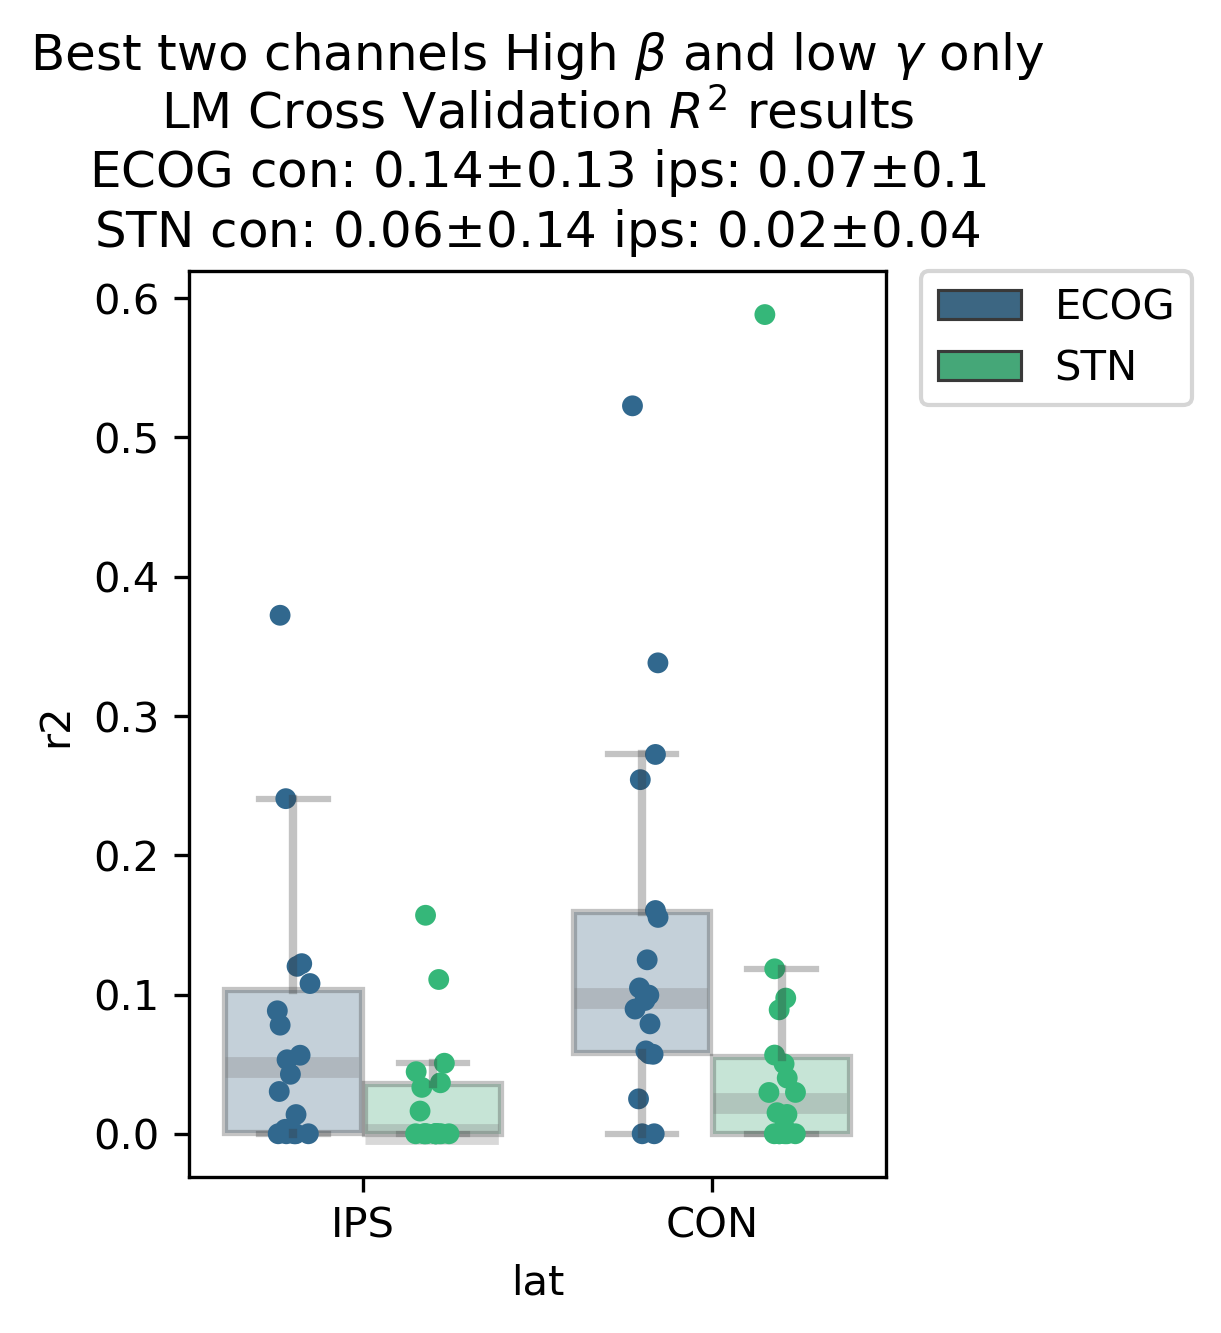

In [26]:
alpha_box = 0.3
plt.figure(figsize=(3,4), dpi=300)
sb.boxplot(x="lat", y="r2", hue="loc", order=["IPS", "CON"], data=df_res,
           palette="viridis", 
           showmeans=False, boxprops=dict(alpha=alpha_box), showcaps=True, showbox=True, 
           showfliers=False, notch=False,
           whiskerprops={'linewidth':2, "zorder":10, "alpha":alpha_box},
           capprops={"alpha":alpha_box},
           medianprops=dict(linestyle='-.', linewidth=5, color="gray", alpha=alpha_box))

    
ax = sb.stripplot(x="lat", y="r2", hue="loc", order=["IPS", "CON"], 
             data=df_res, palette="viridis", dodge=True, s=5)
#plt.xticks(rotation=90)

# When creating the legend, only use the first two elements
# to effectively remove the last two.
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Best two channels High "+r"$\beta$"+ " and low "+r"$\gamma$"+ " only"+\
          "\nLM Cross Validation "+r"$R^2$"+" results\nECOG con: "+s_ECOG_CON+ " ips: "+s_ECOG_IPS+\
         "\nSTN con: "+s_STN_CON+ " ips: "+s_STN_IPS)

### LM Now ALL f bands 

In [27]:
# COMBINATION ECOG
model = linear_model.LinearRegression()
df_res = pd.DataFrame()
time_stamps = 5
NUM_extract = 2

for ch_USED in [["ECOG"], ["STN"]]:
    for f in range(len(os.listdir(PATH_))):
        sub_ = os.listdir(PATH_)[f][4:7]
        if sub_ not in ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']:
            continue
        print(sub_)
        for hem in ["LEFT", "RIGHT"]:
            with open(PATH_+ '\\'+ os.listdir(PATH_)[f], 'rb') as handle:
                run_ = pickle.load(handle)
                print(run_["ch_names"])
                if len([ch for ch in run_["ch_names"] if "STN" in ch]) == 0:
                    continue

                for label_idx, label in enumerate(run_["label_baseline_corrected"]):
                    
                    if run_["label_con_true"][label_idx] is True:
                        lat = "CON"
                    else:
                        lat = "IPS"
                    if ch_USED == ["ECOG"]:
                        loc_here = "ECOG"
                    elif ch_USED == ["STN"]:
                        loc_here = "STN"
                    else:
                        loc_here = "ECOG_STN"
                    
                    #ch_idx = get_idx(run_["ch_names"], ch_USED)
                    ch_idx = get_idx_best_N(hem, lat, sub_, loc_here, run_["ch_names"], NUM_extract = NUM_extract)

                    if len(ch_idx) == 0:
                        continue
                    print("PROCESS")
                    X_ = []
                    # the LABEL is not needed here... 
                    print(ch_idx)
                    print(run_["ch_names"])
                    start = True
                    for ch_idx_ in ch_idx:
                        X, y = append_time_dim(run_["rf_data_median"][:,ch_idx_,:], \
                                               run_["label_baseline_corrected"][0,:], \
                                               time_stamps=time_stamps)
                        if start == True:
                            X_ = X
                            start = False
                        else:
                            X_ = np.concatenate((X_, X), axis=1)

                    res_ = np.mean(cross_val_score(model, X_, label[time_stamps:], cv=3, scoring="r2", n_jobs=59))
                    if res_ < 0:
                        res_ = 0
                        
                    df_res = df_res.append({
                        "r2": res_,
                        #"ch_": ch_,
                        "sub": sub_,
                        "loc": loc_here,
                        "lat": lat
                    }, ignore_index=True)


000
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
000
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
000
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
000
['STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
Empty DataFrame
Columns: [ch_, hem, lat, loc, r2, sub]
Index: []
Empty DataFrame
Colu

             ch_   hem  lat   loc        r2  sub
25   ECOG_LEFT_0  LEFT  IPS  ECOG  0.064250  001
27   ECOG_LEFT_1  LEFT  IPS  ECOG  0.065847  001
29   ECOG_LEFT_2  LEFT  IPS  ECOG  0.078489  001
31   ECOG_LEFT_3  LEFT  IPS  ECOG  0.083842  001
33   ECOG_LEFT_4  LEFT  IPS  ECOG  0.094246  001
35   ECOG_LEFT_5  LEFT  IPS  ECOG  0.093902  001
37   ECOG_LEFT_6  LEFT  IPS  ECOG  0.107735  001
39   ECOG_LEFT_7  LEFT  IPS  ECOG  0.106639  001
41   ECOG_LEFT_8  LEFT  IPS  ECOG  0.099899  001
43   ECOG_LEFT_9  LEFT  IPS  ECOG  0.120339  001
45  ECOG_LEFT_10  LEFT  IPS  ECOG  0.126492  001
47  ECOG_LEFT_11  LEFT  IPS  ECOG  0.113481  001
49  ECOG_LEFT_12  LEFT  IPS  ECOG  0.084958  001
51  ECOG_LEFT_13  LEFT  IPS  ECOG  0.099823  001
53  ECOG_LEFT_14  LEFT  IPS  ECOG  0.075020  001
55  ECOG_LEFT_15  LEFT  IPS  ECOG  0.083968  001
57  ECOG_LEFT_16  LEFT  IPS  ECOG  0.080428  001
59  ECOG_LEFT_17  LEFT  IPS  ECOG  0.083866  001
61  ECOG_LEFT_18  LEFT  IPS  ECOG  0.082491  001
63  ECOG_LEFT_19  LE

['STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'ECOG_RIGHT_6', 'ECOG_RIGHT_7', 'ECOG_RIGHT_8', 'ECOG_RIGHT_9', 'ECOG_RIGHT_10', 'ECOG_RIGHT_11', 'ECOG_RIGHT_12', 'ECOG_RIGHT_13', 'ECOG_RIGHT_14', 'ECOG_RIGHT_15', 'ECOG_RIGHT_16', 'ECOG_RIGHT_17', 'ECOG_RIGHT_18', 'ECOG_RIGHT_19', 'ECOG_RIGHT_20', 'ECOG_RIGHT_21', 'ECOG_RIGHT_22', 'ECOG_RIGHT_23', 'ECOG_RIGHT_24', 'ECOG_RIGHT_25', 'ECOG_RIGHT_26', 'ECOG_RIGHT_27', 'MOV_RIGHT', 'MOV_LEFT']
               ch_    hem  lat   loc        r2  sub
86    ECOG_RIGHT_0  RIGHT  IPS  ECOG  0.033740  001
88    ECOG_RIGHT_1  RIGHT  IPS  ECOG  0.028421  001
90    ECOG_RIGHT_2  RIGHT  IPS  ECOG  0.036561  001
92    ECOG_RIGHT_3  RIGHT  IPS  ECOG  0.050552  001
94    ECOG_RIGHT_4  RIGHT  IPS  ECOG  0.066252  001
96    ECOG_RIGHT_5  RIGHT  IPS  ECOG  0.077707  001
98    ECOG_RIGHT_6  RIGHT  IPS  ECOG  0.071030  001
100   ECOG_RIGHT_7  RIGHT  IPS  ECOG  0.052281 

['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'ECOG_RIGHT_6', 'ECOG_RIGHT_7', 'MOV_RIGHT', 'MOV_LEFT']
004
['STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'ECOG_RIGHT_6', 'ECOG_RIGHT_7', 'MOV_RIGHT', 'MOV_LEFT']
             ch_   hem  lat   loc        r2  sub
149  ECOG_LEFT_0  LEFT  IPS  ECOG  0.000000  004
151  ECOG_LEFT_1  LEFT  IPS  ECOG  0.000000  004
153  ECOG_LEFT_2  LEFT  IPS  ECOG  0.000000  004
155  ECOG_LEFT_3  LEFT  IPS  ECOG  0.015221  004
157  ECOG_LEFT_4  LEFT  IPS  ECOG  0.000000  004
159  ECOG_LEFT_5  LEFT  IPS  ECOG  0.000000  004
161  ECOG_LEFT_6  LEFT  IPS  ECOG  0.038585  004
163  ECOG_LEFT_7  LEFT  IPS  ECOG  0.000000  004
             ch_   hem  lat   loc   r2  sub
148  ECOG_LEFT_0  LEFT  CON  ECOG  0.0  004
150  ECOG_LEFT_1  LEFT  CON  ECOG  0.0  004
152  ECOG_LEFT_2  LEFT  CON  ECOG  0.0  004
154  ECOG_LEFT_3  LEFT  CO

006
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'ECOG_LEFT_8', 'ECOG_LEFT_9', 'ECOG_LEFT_10', 'ECOG_LEFT_11', 'ECOG_LEFT_12', 'ECOG_LEFT_13', 'ECOG_LEFT_14', 'ECOG_LEFT_15', 'ECOG_LEFT_16', 'ECOG_LEFT_17', 'ECOG_LEFT_18', 'ECOG_LEFT_19', 'ECOG_LEFT_20', 'ECOG_LEFT_21', 'ECOG_LEFT_22', 'ECOG_LEFT_23', 'ECOG_LEFT_24', 'ECOG_LEFT_25', 'ECOG_LEFT_26', 'ECOG_LEFT_27', 'ECOG_LEFT_28', 'ECOG_LEFT_29', 'ECOG_LEFT_30', 'ECOG_LEFT_31', 'ECOG_LEFT_32', 'ECOG_LEFT_33', 'ECOG_LEFT_34', 'MOV_RIGHT', 'MOV_LEFT']
              ch_   hem  lat   loc        r2  sub
236   ECOG_LEFT_0  LEFT  CON  ECOG  0.000000  006
238   ECOG_LEFT_1  LEFT  CON  ECOG  0.000000  006
240   ECOG_LEFT_2  LEFT  CON  ECOG  0.000000  006
242   ECOG_LEFT_3  LEFT  CON  ECOG  0.000000  006
244   ECOG_LEFT_4  LEFT  CON  ECOG  0.000000  006
..            ...   ...  ...   ...       ...  ...
452  ECOG_LEFT_31  LEFT  CON

              ch_   hem  lat   loc        r2  sub
237   ECOG_LEFT_0  LEFT  IPS  ECOG  0.000000  006
239   ECOG_LEFT_1  LEFT  IPS  ECOG  0.000000  006
241   ECOG_LEFT_2  LEFT  IPS  ECOG  0.000000  006
243   ECOG_LEFT_3  LEFT  IPS  ECOG  0.000000  006
245   ECOG_LEFT_4  LEFT  IPS  ECOG  0.000000  006
..            ...   ...  ...   ...       ...  ...
453  ECOG_LEFT_31  LEFT  IPS  ECOG  0.041179  006
455  ECOG_LEFT_32  LEFT  IPS  ECOG  0.019931  006
457  ECOG_LEFT_33  LEFT  IPS  ECOG  0.032975  006
459  ECOG_LEFT_34  LEFT  IPS  ECOG  0.052508  006
461  ECOG_LEFT_35  LEFT  IPS  ECOG  0.042050  006

[107 rows x 6 columns]
PROCESS
[28, 29]
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'ECOG_LEFT_8', 'ECOG_LEFT_9', 'ECOG_LEFT_10', 'ECOG_LEFT_11', 'ECOG_LEFT_12', 'ECOG_LEFT_13', 'ECOG_LEFT_14', 'ECOG_LEFT_15', 'ECOG_LEFT_16', 'ECOG_LEFT_17', 'ECOG_LEFT_18', 'ECOG_LEFT_19', 'ECOG_

['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'ECOG_LEFT_8', 'ECOG_LEFT_9', 'ECOG_LEFT_10', 'ECOG_LEFT_11', 'ECOG_LEFT_12', 'ECOG_LEFT_13', 'ECOG_LEFT_14', 'ECOG_LEFT_15', 'ECOG_LEFT_16', 'ECOG_LEFT_17', 'ECOG_LEFT_18', 'ECOG_LEFT_19', 'ECOG_LEFT_20', 'ECOG_LEFT_21', 'ECOG_LEFT_22', 'ECOG_LEFT_23', 'ECOG_LEFT_24', 'ECOG_LEFT_25', 'ECOG_LEFT_26', 'ECOG_LEFT_27', 'ECOG_LEFT_28', 'ECOG_LEFT_29', 'ECOG_LEFT_30', 'ECOG_LEFT_31', 'ECOG_LEFT_32', 'ECOG_LEFT_33', 'ECOG_LEFT_34', 'ECOG_LEFT_35', 'MOV_RIGHT', 'MOV_LEFT']
               ch_    hem  lat   loc        r2  sub
469   ECOG_RIGHT_0  RIGHT  CON  ECOG  0.000000  006
471   ECOG_RIGHT_1  RIGHT  CON  ECOG  0.000000  006
473   ECOG_RIGHT_2  RIGHT  CON  ECOG  0.000000  006
475   ECOG_RIGHT_3  RIGHT  CON  ECOG  0.000000  006
477   ECOG_RIGHT_4  RIGHT  CON  ECOG  0.000000  006
479   ECOG_RIGHT_5  RIGHT  CON  ECOG  0.000000  006
48

['STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'ECOG_RIGHT_6', 'ECOG_RIGHT_7', 'ECOG_RIGHT_8', 'ECOG_RIGHT_9', 'ECOG_RIGHT_10', 'ECOG_RIGHT_11', 'ECOG_RIGHT_12', 'ECOG_RIGHT_13', 'ECOG_RIGHT_14', 'ECOG_RIGHT_15', 'ECOG_RIGHT_16', 'ECOG_RIGHT_17', 'ECOG_RIGHT_18', 'ECOG_RIGHT_19', 'ECOG_RIGHT_20', 'ECOG_RIGHT_21', 'ECOG_RIGHT_22', 'ECOG_RIGHT_23', 'ECOG_RIGHT_24', 'ECOG_RIGHT_25', 'ECOG_RIGHT_26', 'ECOG_RIGHT_27', 'ECOG_RIGHT_28', 'ECOG_RIGHT_29', 'ECOG_RIGHT_30', 'ECOG_RIGHT_31', 'ECOG_RIGHT_32', 'ECOG_RIGHT_33', 'ECOG_RIGHT_34', 'ECOG_RIGHT_35', 'MOV_RIGHT', 'MOV_LEFT']
               ch_    hem  lat   loc        r2  sub
468   ECOG_RIGHT_0  RIGHT  IPS  ECOG  0.000000  006
470   ECOG_RIGHT_1  RIGHT  IPS  ECOG  0.000000  006
472   ECOG_RIGHT_2  RIGHT  IPS  ECOG  0.000000  006
474   ECOG_RIGHT_3  RIGHT  IPS  ECOG  0.000000  006
476   ECOG_RIGHT_4  RIGHT  IPS  ECOG  0.000000  006
478   ECOG_RIGH

['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
             ch_   hem  lat   loc        r2  sub
564  ECOG_LEFT_0  LEFT  CON  ECOG  0.126261  008
566  ECOG_LEFT_1  LEFT  CON  ECOG  0.245784  008
568  ECOG_LEFT_2  LEFT  CON  ECOG  0.186866  008
570  ECOG_LEFT_3  LEFT  CON  ECOG  0.100402  008
572  ECOG_LEFT_4  LEFT  CON  ECOG  0.026821  008
574  ECOG_LEFT_5  LEFT  CON  ECOG  0.017294  008
PROCESS
[4, 5]
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
             ch_   hem  lat   loc   r2  sub
565  ECOG_LEFT_0  LEFT  IPS  ECOG  0.0  008
567  ECOG_LEFT_1  LEFT  IPS  ECOG  0.0  008
569  ECOG_LEFT_2  LEFT  IPS  ECOG  0.0  008
571  ECOG_LEFT_3  LEFT  IPS  ECOG  0.0  008
573  ECOG_LEFT_4  LEFT  IPS  ECOG  0.0  008
575  ECOG_LEFT_5  LEFT  IPS  ECOG  0.0  008
PROCESS
[3, 4]
['S

611  ECOG_LEFT_5  LEFT  IPS  ECOG  0.0  010
             ch_   hem  lat   loc        r2  sub
600  ECOG_LEFT_0  LEFT  CON  ECOG  0.171688  010
602  ECOG_LEFT_1  LEFT  CON  ECOG  0.186032  010
604  ECOG_LEFT_2  LEFT  CON  ECOG  0.000000  010
606  ECOG_LEFT_3  LEFT  CON  ECOG  0.012055  010
608  ECOG_LEFT_4  LEFT  CON  ECOG  0.000000  010
610  ECOG_LEFT_5  LEFT  CON  ECOG  0.018338  010
['STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
              ch_    hem  lat   loc        r2  sub
618  ECOG_RIGHT_0  RIGHT  IPS  ECOG  0.007545  010
620  ECOG_RIGHT_1  RIGHT  IPS  ECOG  0.000000  010
622  ECOG_RIGHT_2  RIGHT  IPS  ECOG  0.000000  010
624  ECOG_RIGHT_3  RIGHT  IPS  ECOG  0.000000  010
626  ECOG_RIGHT_4  RIGHT  IPS  ECOG  0.006979  010
628  ECOG_RIGHT_5  RIGHT  IPS  ECOG  0.000000  010
PROCESS
[3, 7]
['STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'ECOG_RIGHT_0', 'ECOG_RIGHT_

001
['ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'ECOG_LEFT_8', 'ECOG_LEFT_9', 'ECOG_LEFT_10', 'ECOG_LEFT_11', 'ECOG_LEFT_12', 'ECOG_LEFT_13', 'ECOG_LEFT_14', 'ECOG_LEFT_15', 'ECOG_LEFT_16', 'ECOG_LEFT_17', 'ECOG_LEFT_18', 'ECOG_LEFT_19', 'ECOG_LEFT_20', 'ECOG_LEFT_21', 'ECOG_LEFT_22', 'ECOG_LEFT_23', 'ECOG_LEFT_24', 'ECOG_LEFT_25', 'ECOG_LEFT_26', 'ECOG_LEFT_27', 'MOV_RIGHT', 'MOV_LEFT']
['ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'ECOG_LEFT_8', 'ECOG_LEFT_9', 'ECOG_LEFT_10', 'ECOG_LEFT_11', 'ECOG_LEFT_12', 'ECOG_LEFT_13', 'ECOG_LEFT_14', 'ECOG_LEFT_15', 'ECOG_LEFT_16', 'ECOG_LEFT_17', 'ECOG_LEFT_18', 'ECOG_LEFT_19', 'ECOG_LEFT_20', 'ECOG_LEFT_21', 'ECOG_LEFT_22', 'ECOG_LEFT_23', 'ECOG_LEFT_24', 'ECOG_LEFT_25', 'ECOG_LEFT_26', 'ECOG_LEFT_27', 'MOV_RIGHT', 'MOV_LEFT']
001
['ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'EC

001
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'ECOG_RIGHT_6', 'ECOG_RIGHT_7', 'ECOG_RIGHT_8', 'ECOG_RIGHT_9', 'ECOG_RIGHT_10', 'ECOG_RIGHT_11', 'ECOG_RIGHT_12', 'ECOG_RIGHT_13', 'ECOG_RIGHT_14', 'ECOG_RIGHT_15', 'ECOG_RIGHT_16', 'ECOG_RIGHT_17', 'ECOG_RIGHT_18', 'ECOG_RIGHT_19', 'ECOG_RIGHT_20', 'ECOG_RIGHT_21', 'ECOG_RIGHT_22', 'ECOG_RIGHT_23', 'ECOG_RIGHT_24', 'ECOG_RIGHT_25', 'ECOG_RIGHT_26', 'ECOG_RIGHT_27', 'MOV_RIGHT', 'MOV_LEFT']
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'ECOG_RIGHT_6', 'ECOG_RIGHT_7', 'ECOG_RIGHT_8', 'ECOG_RIGHT_9', 'ECOG_RIGHT_10', 'ECOG_RIGHT_11', 'ECOG_RIGHT_12', 'ECOG_RIGHT_13', 'ECOG_RIGHT_14', 'ECOG_RIGHT_15', 'ECOG_RIGHT_16', 'ECOG_RIGHT_17', 'ECOG_RIGHT_18', 'ECOG_RIGHT_19', 'ECOG_RIGHT_20', 'ECOG_RIGHT_21', 'ECOG_RIGHT_22', 'ECOG_RIGHT_23', 'ECOG_RIGHT_24', 'ECOG_RIGHT_25', 'ECOG_RIGHT_26', 'ECOG_RIGHT_27', 'MOV_RIGHT', 'MOV_LEFT']
001
['ECOG_R

PROCESS
[0, 1]
['STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'ECOG_RIGHT_6', 'ECOG_RIGHT_7', 'MOV_RIGHT', 'MOV_LEFT']
             ch_    hem  lat  loc        r2  sub
209  STN_RIGHT_0  RIGHT  CON  STN  0.024878  005
211  STN_RIGHT_1  RIGHT  CON  STN  0.031274  005
213  STN_RIGHT_2  RIGHT  CON  STN  0.004545  005
PROCESS
[0, 1]
['STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'ECOG_RIGHT_6', 'ECOG_RIGHT_7', 'MOV_RIGHT', 'MOV_LEFT']
006
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'ECOG_LEFT_8', 'ECOG_LEFT_9', 'ECOG_LEFT_10', 'ECOG_LEFT_11', 'ECOG_LEFT_12', 'ECOG_LEFT_13', 'ECOG_LEFT_14', 'ECOG_LEFT_15', 'ECOG_LEFT_16', 'ECOG_LEFT_17', 'ECOG_LEFT_18', 'ECOG_LEFT_19', 'ECOG_LEFT_20', 'EC

['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'ECOG_LEFT_8', 'ECOG_LEFT_9', 'ECOG_LEFT_10', 'ECOG_LEFT_11', 'ECOG_LEFT_12', 'ECOG_LEFT_13', 'ECOG_LEFT_14', 'ECOG_LEFT_15', 'ECOG_LEFT_16', 'ECOG_LEFT_17', 'ECOG_LEFT_18', 'ECOG_LEFT_19', 'ECOG_LEFT_20', 'ECOG_LEFT_21', 'ECOG_LEFT_22', 'ECOG_LEFT_23', 'ECOG_LEFT_24', 'ECOG_LEFT_25', 'ECOG_LEFT_26', 'ECOG_LEFT_27', 'ECOG_LEFT_28', 'ECOG_LEFT_29', 'ECOG_LEFT_30', 'ECOG_LEFT_31', 'ECOG_LEFT_32', 'ECOG_LEFT_33', 'ECOG_LEFT_34', 'ECOG_LEFT_35', 'MOV_RIGHT', 'MOV_LEFT']
            ch_   hem  lat  loc        r2  sub
230  STN_LEFT_0  LEFT  CON  STN  0.015891  006
232  STN_LEFT_1  LEFT  CON  STN  0.057660  006
234  STN_LEFT_2  LEFT  CON  STN  0.012253  006
306  STN_LEFT_0  LEFT  CON  STN  0.037314  006
308  STN_LEFT_1  LEFT  CON  STN  0.030299  006
310  STN_LEFT_2  LEFT  CON  STN  0.033847  006
384  STN_LEFT_0  LEFT  CON  STN  0.00

             ch_    hem  lat  loc   r2  sub
463  STN_RIGHT_0  RIGHT  CON  STN  0.0  006
465  STN_RIGHT_1  RIGHT  CON  STN  0.0  006
467  STN_RIGHT_2  RIGHT  CON  STN  0.0  006
PROCESS
[0, 1]
['STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'ECOG_RIGHT_6', 'ECOG_RIGHT_7', 'ECOG_RIGHT_8', 'ECOG_RIGHT_9', 'ECOG_RIGHT_10', 'ECOG_RIGHT_11', 'ECOG_RIGHT_12', 'ECOG_RIGHT_13', 'ECOG_RIGHT_14', 'ECOG_RIGHT_15', 'ECOG_RIGHT_16', 'ECOG_RIGHT_17', 'ECOG_RIGHT_18', 'ECOG_RIGHT_19', 'ECOG_RIGHT_20', 'ECOG_RIGHT_21', 'ECOG_RIGHT_22', 'ECOG_RIGHT_23', 'ECOG_RIGHT_24', 'ECOG_RIGHT_25', 'ECOG_RIGHT_26', 'ECOG_RIGHT_27', 'ECOG_RIGHT_28', 'ECOG_RIGHT_29', 'ECOG_RIGHT_30', 'ECOG_RIGHT_31', 'ECOG_RIGHT_32', 'ECOG_RIGHT_33', 'ECOG_RIGHT_34', 'ECOG_RIGHT_35', 'MOV_RIGHT', 'MOV_LEFT']
006
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'ECOG_RIGHT_6', 'ECOG_RIGHT_7', 'EC

['ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
['ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
010
['ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
['ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
010
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
010
['STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
            ch_   hem  lat  loc   r2  sub
595  STN_LEFT_0  LEFT  IPS  STN  0.0  010
597  STN_LEFT_1  LEFT  IPS  S

In [28]:
s_ECOG_CON = str(np.round(df_res[(df_res["lat"] == "CON") & (df_res["loc"] == "ECOG")]["r2"].mean(), 2))+\
                 r"$\pm$"+str(np.round(df_res[(df_res["lat"] == "CON") & (df_res["loc"] == "ECOG")]["r2"].std(),2))
s_ECOG_IPS = str(np.round(df_res[(df_res["lat"] == "IPS") & (df_res["loc"] == "ECOG")]["r2"].mean(), 2))+\
                 r"$\pm$"+str(np.round(df_res[(df_res["lat"] == "IPS") & (df_res["loc"] == "ECOG")]["r2"].std(),2))
s_STN_CON = str(np.round(df_res[(df_res["lat"] == "CON") & (df_res["loc"] == "STN")]["r2"].mean(), 2))+\
                 r"$\pm$"+str(np.round(df_res[(df_res["lat"] == "CON") & (df_res["loc"] == "STN")]["r2"].std(),2))
s_STN_IPS = str(np.round(df_res[(df_res["lat"] == "IPS") & (df_res["loc"] == "STN")]["r2"].mean(), 2))+\
                 r"$\pm$"+str(np.round(df_res[(df_res["lat"] == "IPS") & (df_res["loc"] == "STN")]["r2"].std(),2))           

Text(0.5, 1.0, 'Best two channels all f bands\nLM Cross Validation $R^2$ results\nECOG con: 0.17$\\pm$0.15 ips: 0.09$\\pm$0.11\nSTN con: 0.06$\\pm$0.14 ips: 0.04$\\pm$0.07')

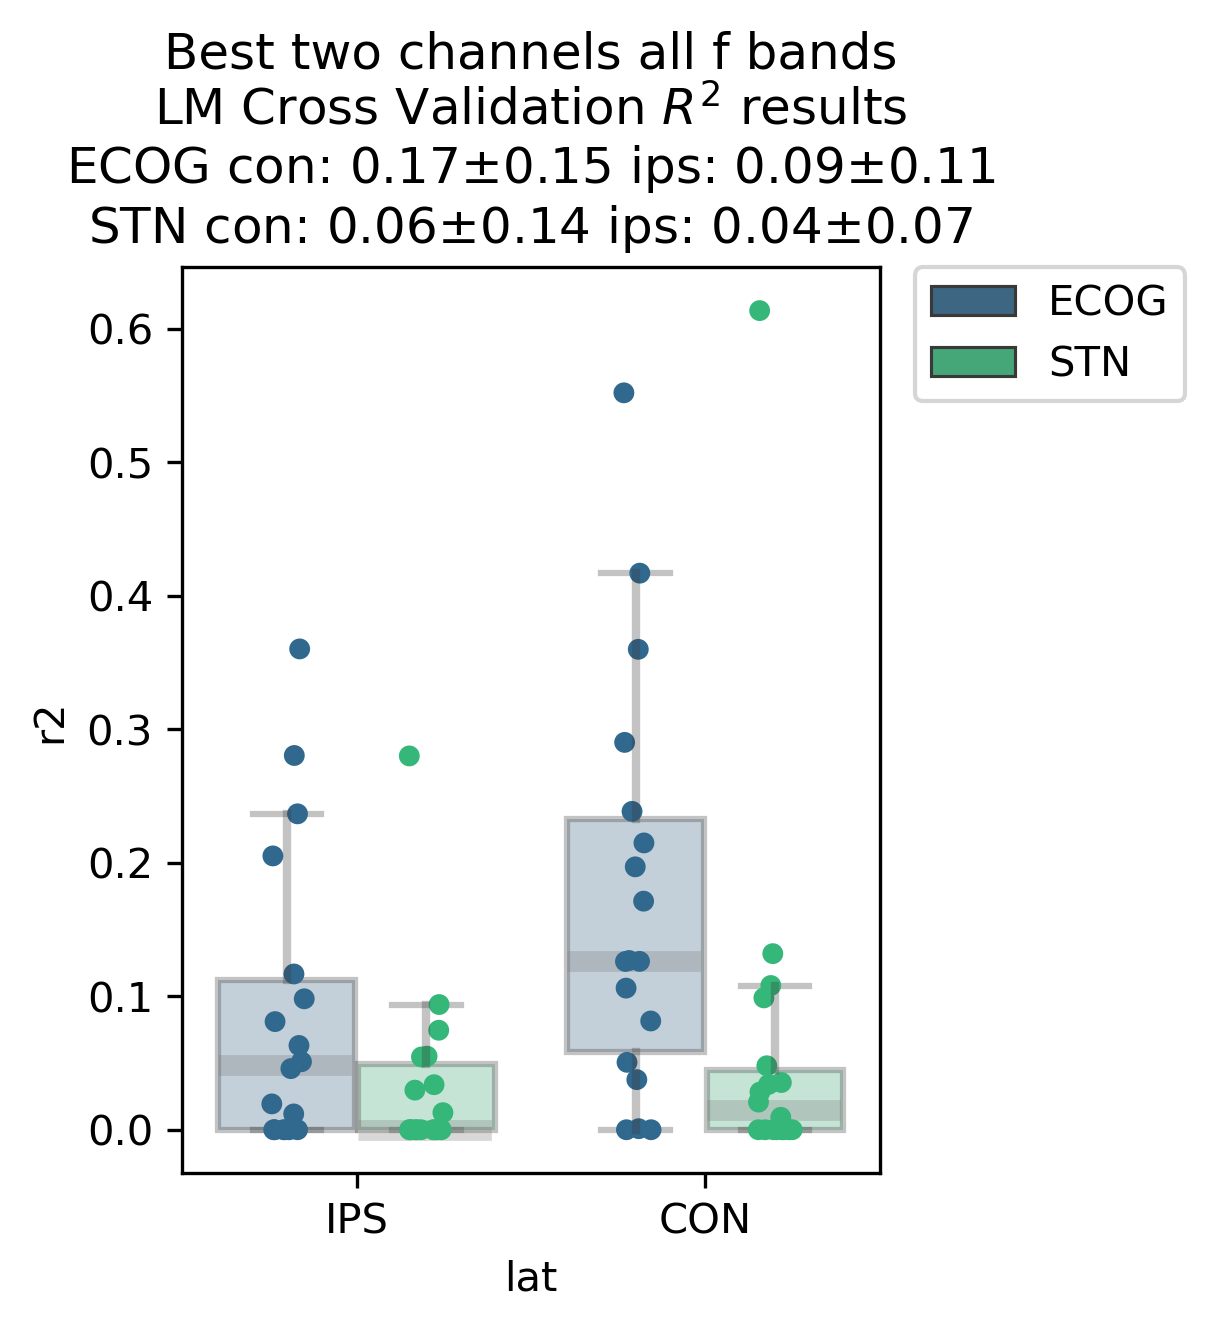

In [29]:
alpha_box = 0.3
plt.figure(figsize=(3,4), dpi=300)
sb.boxplot(x="lat", y="r2", hue="loc", order=["IPS", "CON"], data=df_res,
           palette="viridis", 
           showmeans=False, boxprops=dict(alpha=alpha_box), showcaps=True, showbox=True, 
           showfliers=False, notch=False,
           whiskerprops={'linewidth':2, "zorder":10, "alpha":alpha_box},
           capprops={"alpha":alpha_box},
           medianprops=dict(linestyle='-.', linewidth=5, color="gray", alpha=alpha_box))

    
ax = sb.stripplot(x="lat", y="r2", hue="loc", order=["IPS", "CON"], 
             data=df_res, palette="viridis", dodge=True, s=5)
#plt.xticks(rotation=90)

# When creating the legend, only use the first two elements
# to effectively remove the last two.
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Best two channels all f bands"+\
          "\nLM Cross Validation "+r"$R^2$"+" results\nECOG con: "+s_ECOG_CON+ " ips: "+s_ECOG_IPS+\
         "\nSTN con: "+s_STN_CON+ " ips: "+s_STN_IPS)

### XGB

In [7]:
df = pd.read_pickle("XGB_all_ECOGSTN_samesize.p")

In [8]:
# COMBINATION ECOG
model = linear_model.LinearRegression()
df_res = pd.DataFrame()
time_stamps = 5
NUM_extract = 2

for ch_USED in [["ECOG"], ["STN"]]:
    for f in range(len(os.listdir(PATH_))):
        sub_ = os.listdir(PATH_)[f][4:7]
        if sub_ not in ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']:
            continue
        print(sub_)
        for hem in ["LEFT", "RIGHT"]:
            with open(PATH_+ '\\'+ os.listdir(PATH_)[f], 'rb') as handle:
                run_ = pickle.load(handle)
                print(run_["ch_names"])
                if len([ch for ch in run_["ch_names"] if "STN" in ch]) == 0:
                    continue

                for label_idx, label in enumerate(run_["label_baseline_corrected"]):
                    
                    if run_["label_con_true"][label_idx] is True:
                        lat = "CON"
                    else:
                        lat = "IPS"
                    if ch_USED == ["ECOG"]:
                        loc_here = "ECOG"
                    elif ch_USED == ["STN"]:
                        loc_here = "STN"
                    else:
                        loc_here = "ECOG_STN"
                    
                    #ch_idx = get_idx(run_["ch_names"], ch_USED)
                    ch_idx = get_idx_best_N(hem, lat, sub_, loc_here, run_["ch_names"], NUM_extract = NUM_extract)

                    if len(ch_idx) == 0:
                        continue
                    print("PROCESS")
                    X_ = []
                    # the LABEL is not needed here... 
                    print(ch_idx)
                    print(run_["ch_names"])
                    start = True
                    for ch_idx_ in ch_idx:
                        X, y = append_time_dim(run_["rf_data_median"][:,ch_idx_,[3,5]], \
                                               run_["label_baseline_corrected"][0,:], \
                                               time_stamps=time_stamps)
                        if start == True:
                            X_ = X
                            start = False
                        else:
                            X_ = np.concatenate((X_, X), axis=1)

                    res_ = xgb.cv(xgb.XGBRegressor().get_params(), dtrain=xgb.DMatrix(X_, label=y), 
                              feval=evalerror, nfold=3, shuffle=False).iloc[-1]["test-r2-mean"]
                    if res_ < 0:
                        res_ = 0
                        
                    df_res = df_res.append({
                        "r2": res_,
                        #"ch_": ch_,
                        "sub": sub_,
                        "loc": loc_here,
                        "lat": lat
                    }, ignore_index=True)


000
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
000
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
000
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
000
['STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
Empty DataFrame
Columns: [ch_, hem, lat, loc, r2, sub]
Index: []
Empty DataFrame
Colu

             ch_   hem  lat   loc        r2  sub
25   ECOG_LEFT_0  LEFT  IPS  ECOG  0.044354  001
27   ECOG_LEFT_1  LEFT  IPS  ECOG  0.039572  001
29   ECOG_LEFT_2  LEFT  IPS  ECOG  0.119015  001
31   ECOG_LEFT_3  LEFT  IPS  ECOG  0.020518  001
33   ECOG_LEFT_4  LEFT  IPS  ECOG  0.074045  001
35   ECOG_LEFT_5  LEFT  IPS  ECOG  0.166431  001
37   ECOG_LEFT_6  LEFT  IPS  ECOG  0.196157  001
39   ECOG_LEFT_7  LEFT  IPS  ECOG  0.158656  001
41   ECOG_LEFT_8  LEFT  IPS  ECOG  0.100668  001
43   ECOG_LEFT_9  LEFT  IPS  ECOG  0.161383  001
45  ECOG_LEFT_10  LEFT  IPS  ECOG  0.147066  001
47  ECOG_LEFT_11  LEFT  IPS  ECOG  0.119299  001
49  ECOG_LEFT_12  LEFT  IPS  ECOG  0.000000  001
51  ECOG_LEFT_13  LEFT  IPS  ECOG  0.069895  001
53  ECOG_LEFT_14  LEFT  IPS  ECOG  0.041358  001
55  ECOG_LEFT_15  LEFT  IPS  ECOG  0.018451  001
57  ECOG_LEFT_16  LEFT  IPS  ECOG  0.051884  001
59  ECOG_LEFT_17  LEFT  IPS  ECOG  0.044626  001
61  ECOG_LEFT_18  LEFT  IPS  ECOG  0.025048  001
63  ECOG_LEFT_19  LE

['STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'ECOG_RIGHT_6', 'ECOG_RIGHT_7', 'ECOG_RIGHT_8', 'ECOG_RIGHT_9', 'ECOG_RIGHT_10', 'ECOG_RIGHT_11', 'ECOG_RIGHT_12', 'ECOG_RIGHT_13', 'ECOG_RIGHT_14', 'ECOG_RIGHT_15', 'ECOG_RIGHT_16', 'ECOG_RIGHT_17', 'ECOG_RIGHT_18', 'ECOG_RIGHT_19', 'ECOG_RIGHT_20', 'ECOG_RIGHT_21', 'ECOG_RIGHT_22', 'ECOG_RIGHT_23', 'ECOG_RIGHT_24', 'ECOG_RIGHT_25', 'ECOG_RIGHT_26', 'ECOG_RIGHT_27', 'MOV_RIGHT', 'MOV_LEFT']
               ch_    hem  lat   loc        r2  sub
86    ECOG_RIGHT_0  RIGHT  IPS  ECOG  0.012854  001
88    ECOG_RIGHT_1  RIGHT  IPS  ECOG  0.014349  001
90    ECOG_RIGHT_2  RIGHT  IPS  ECOG  0.049305  001
92    ECOG_RIGHT_3  RIGHT  IPS  ECOG  0.047369  001
94    ECOG_RIGHT_4  RIGHT  IPS  ECOG  0.021942  001
96    ECOG_RIGHT_5  RIGHT  IPS  ECOG  0.083808  001
98    ECOG_RIGHT_6  RIGHT  IPS  ECOG  0.050589  001
100   ECOG_RIGHT_7  RIGHT  IPS  ECOG  0.005915 

['STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'ECOG_RIGHT_6', 'ECOG_RIGHT_7', 'MOV_RIGHT', 'MOV_LEFT']
             ch_   hem  lat   loc        r2  sub
149  ECOG_LEFT_0  LEFT  IPS  ECOG  0.161563  004
151  ECOG_LEFT_1  LEFT  IPS  ECOG  0.077200  004
153  ECOG_LEFT_2  LEFT  IPS  ECOG  0.120292  004
155  ECOG_LEFT_3  LEFT  IPS  ECOG  0.091100  004
157  ECOG_LEFT_4  LEFT  IPS  ECOG  0.159328  004
159  ECOG_LEFT_5  LEFT  IPS  ECOG  0.086927  004
161  ECOG_LEFT_6  LEFT  IPS  ECOG  0.203582  004
163  ECOG_LEFT_7  LEFT  IPS  ECOG  0.037336  004
             ch_   hem  lat   loc        r2  sub
148  ECOG_LEFT_0  LEFT  CON  ECOG  0.033590  004
150  ECOG_LEFT_1  LEFT  CON  ECOG  0.014475  004
152  ECOG_LEFT_2  LEFT  CON  ECOG  0.024913  004
154  ECOG_LEFT_3  LEFT  CON  ECOG  0.013034  004
156  ECOG_LEFT_4  LEFT  CON  ECOG  0.013289  004
158  ECOG_LEFT_5  LEFT  CON  ECOG  0.011591  004
160  ECOG_LEFT_6 

006
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'ECOG_LEFT_8', 'ECOG_LEFT_9', 'ECOG_LEFT_10', 'ECOG_LEFT_11', 'ECOG_LEFT_12', 'ECOG_LEFT_13', 'ECOG_LEFT_14', 'ECOG_LEFT_15', 'ECOG_LEFT_16', 'ECOG_LEFT_17', 'ECOG_LEFT_18', 'ECOG_LEFT_19', 'ECOG_LEFT_20', 'ECOG_LEFT_21', 'ECOG_LEFT_22', 'ECOG_LEFT_23', 'ECOG_LEFT_24', 'ECOG_LEFT_25', 'ECOG_LEFT_26', 'ECOG_LEFT_27', 'ECOG_LEFT_28', 'ECOG_LEFT_29', 'ECOG_LEFT_30', 'ECOG_LEFT_31', 'ECOG_LEFT_32', 'ECOG_LEFT_33', 'ECOG_LEFT_34', 'MOV_RIGHT', 'MOV_LEFT']
              ch_   hem  lat   loc        r2  sub
236   ECOG_LEFT_0  LEFT  CON  ECOG  0.000000  006
238   ECOG_LEFT_1  LEFT  CON  ECOG  0.000000  006
240   ECOG_LEFT_2  LEFT  CON  ECOG  0.000000  006
242   ECOG_LEFT_3  LEFT  CON  ECOG  0.000000  006
244   ECOG_LEFT_4  LEFT  CON  ECOG  0.000000  006
..            ...   ...  ...   ...       ...  ...
452  ECOG_LEFT_31  LEFT  CON

              ch_   hem  lat   loc        r2  sub
237   ECOG_LEFT_0  LEFT  IPS  ECOG  0.000000  006
239   ECOG_LEFT_1  LEFT  IPS  ECOG  0.000000  006
241   ECOG_LEFT_2  LEFT  IPS  ECOG  0.000000  006
243   ECOG_LEFT_3  LEFT  IPS  ECOG  0.000000  006
245   ECOG_LEFT_4  LEFT  IPS  ECOG  0.000000  006
..            ...   ...  ...   ...       ...  ...
453  ECOG_LEFT_31  LEFT  IPS  ECOG  0.034273  006
455  ECOG_LEFT_32  LEFT  IPS  ECOG  0.000000  006
457  ECOG_LEFT_33  LEFT  IPS  ECOG  0.000000  006
459  ECOG_LEFT_34  LEFT  IPS  ECOG  0.010949  006
461  ECOG_LEFT_35  LEFT  IPS  ECOG  0.000000  006

[107 rows x 6 columns]
PROCESS
[28, 29]
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'ECOG_LEFT_8', 'ECOG_LEFT_9', 'ECOG_LEFT_10', 'ECOG_LEFT_11', 'ECOG_LEFT_12', 'ECOG_LEFT_13', 'ECOG_LEFT_14', 'ECOG_LEFT_15', 'ECOG_LEFT_16', 'ECOG_LEFT_17', 'ECOG_LEFT_18', 'ECOG_LEFT_19', 'ECOG_

['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'ECOG_LEFT_8', 'ECOG_LEFT_9', 'ECOG_LEFT_10', 'ECOG_LEFT_11', 'ECOG_LEFT_12', 'ECOG_LEFT_13', 'ECOG_LEFT_14', 'ECOG_LEFT_15', 'ECOG_LEFT_16', 'ECOG_LEFT_17', 'ECOG_LEFT_18', 'ECOG_LEFT_19', 'ECOG_LEFT_20', 'ECOG_LEFT_21', 'ECOG_LEFT_22', 'ECOG_LEFT_23', 'ECOG_LEFT_24', 'ECOG_LEFT_25', 'ECOG_LEFT_26', 'ECOG_LEFT_27', 'ECOG_LEFT_28', 'ECOG_LEFT_29', 'ECOG_LEFT_30', 'ECOG_LEFT_31', 'ECOG_LEFT_32', 'ECOG_LEFT_33', 'ECOG_LEFT_34', 'ECOG_LEFT_35', 'MOV_RIGHT', 'MOV_LEFT']
               ch_    hem  lat   loc        r2  sub
469   ECOG_RIGHT_0  RIGHT  CON  ECOG  0.000000  006
471   ECOG_RIGHT_1  RIGHT  CON  ECOG  0.000000  006
473   ECOG_RIGHT_2  RIGHT  CON  ECOG  0.000000  006
475   ECOG_RIGHT_3  RIGHT  CON  ECOG  0.000000  006
477   ECOG_RIGHT_4  RIGHT  CON  ECOG  0.000000  006
479   ECOG_RIGHT_5  RIGHT  CON  ECOG  0.000000  006
48

['STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'ECOG_RIGHT_6', 'ECOG_RIGHT_7', 'ECOG_RIGHT_8', 'ECOG_RIGHT_9', 'ECOG_RIGHT_10', 'ECOG_RIGHT_11', 'ECOG_RIGHT_12', 'ECOG_RIGHT_13', 'ECOG_RIGHT_14', 'ECOG_RIGHT_15', 'ECOG_RIGHT_16', 'ECOG_RIGHT_17', 'ECOG_RIGHT_18', 'ECOG_RIGHT_19', 'ECOG_RIGHT_20', 'ECOG_RIGHT_21', 'ECOG_RIGHT_22', 'ECOG_RIGHT_23', 'ECOG_RIGHT_24', 'ECOG_RIGHT_25', 'ECOG_RIGHT_26', 'ECOG_RIGHT_27', 'ECOG_RIGHT_28', 'ECOG_RIGHT_29', 'ECOG_RIGHT_30', 'ECOG_RIGHT_31', 'ECOG_RIGHT_32', 'ECOG_RIGHT_33', 'ECOG_RIGHT_34', 'ECOG_RIGHT_35', 'MOV_RIGHT', 'MOV_LEFT']
               ch_    hem  lat   loc        r2  sub
468   ECOG_RIGHT_0  RIGHT  IPS  ECOG  0.000000  006
470   ECOG_RIGHT_1  RIGHT  IPS  ECOG  0.000000  006
472   ECOG_RIGHT_2  RIGHT  IPS  ECOG  0.000000  006
474   ECOG_RIGHT_3  RIGHT  IPS  ECOG  0.000000  006
476   ECOG_RIGHT_4  RIGHT  IPS  ECOG  0.000000  006
478   ECOG_RIGH

PROCESS
[4, 5]
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
             ch_   hem  lat   loc   r2  sub
565  ECOG_LEFT_0  LEFT  IPS  ECOG  0.0  008
567  ECOG_LEFT_1  LEFT  IPS  ECOG  0.0  008
569  ECOG_LEFT_2  LEFT  IPS  ECOG  0.0  008
571  ECOG_LEFT_3  LEFT  IPS  ECOG  0.0  008
573  ECOG_LEFT_4  LEFT  IPS  ECOG  0.0  008
575  ECOG_LEFT_5  LEFT  IPS  ECOG  0.0  008
PROCESS
[3, 4]
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
Empty DataFrame
Columns: [ch_, hem, lat, loc, r2, sub]
Index: []
Empty DataFrame
Columns: [ch_, hem, lat, loc, r2, sub]
Index: []
008
['ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LE

              ch_    hem  lat   loc        r2  sub
619  ECOG_RIGHT_0  RIGHT  CON  ECOG  0.097979  010
621  ECOG_RIGHT_1  RIGHT  CON  ECOG  0.000000  010
623  ECOG_RIGHT_2  RIGHT  CON  ECOG  0.000000  010
625  ECOG_RIGHT_3  RIGHT  CON  ECOG  0.000000  010
627  ECOG_RIGHT_4  RIGHT  CON  ECOG  0.000000  010
629  ECOG_RIGHT_5  RIGHT  CON  ECOG  0.000000  010
PROCESS
[3, 4]
['STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
013
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
             ch_   hem  lat   loc        r2  sub
636  ECOG_LEFT_0  LEFT  CON  ECOG  0.069603  013
638  ECOG_LEFT_1  LEFT  CON  ECOG  0.044267  013
640  ECOG_LEFT_2  LEFT  CON  ECOG  0.088484  013
642  ECOG_LEFT_3  LEFT  CON  ECOG  0.142148  013
644  ECOG_LEFT_4  LEFT  CON  ECOG  0.103122  013
646  

['ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'ECOG_LEFT_8', 'ECOG_LEFT_9', 'ECOG_LEFT_10', 'ECOG_LEFT_11', 'ECOG_LEFT_12', 'ECOG_LEFT_13', 'ECOG_LEFT_14', 'ECOG_LEFT_15', 'ECOG_LEFT_16', 'ECOG_LEFT_17', 'ECOG_LEFT_18', 'ECOG_LEFT_19', 'ECOG_LEFT_20', 'ECOG_LEFT_21', 'ECOG_LEFT_22', 'ECOG_LEFT_23', 'ECOG_LEFT_24', 'ECOG_LEFT_25', 'ECOG_LEFT_26', 'ECOG_LEFT_27', 'MOV_RIGHT', 'MOV_LEFT']
001
['ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'ECOG_LEFT_8', 'ECOG_LEFT_9', 'ECOG_LEFT_10', 'ECOG_LEFT_11', 'ECOG_LEFT_12', 'ECOG_LEFT_13', 'ECOG_LEFT_14', 'ECOG_LEFT_15', 'ECOG_LEFT_16', 'ECOG_LEFT_17', 'ECOG_LEFT_18', 'ECOG_LEFT_19', 'ECOG_LEFT_20', 'ECOG_LEFT_21', 'ECOG_LEFT_22', 'ECOG_LEFT_23', 'ECOG_LEFT_24', 'ECOG_LEFT_25', 'ECOG_LEFT_26', 'ECOG_LEFT_27', 'MOV_RIGHT', 'MOV_LEFT']
['ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_L

['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'ECOG_RIGHT_6', 'ECOG_RIGHT_7', 'ECOG_RIGHT_8', 'ECOG_RIGHT_9', 'ECOG_RIGHT_10', 'ECOG_RIGHT_11', 'ECOG_RIGHT_12', 'ECOG_RIGHT_13', 'ECOG_RIGHT_14', 'ECOG_RIGHT_15', 'ECOG_RIGHT_16', 'ECOG_RIGHT_17', 'ECOG_RIGHT_18', 'ECOG_RIGHT_19', 'ECOG_RIGHT_20', 'ECOG_RIGHT_21', 'ECOG_RIGHT_22', 'ECOG_RIGHT_23', 'ECOG_RIGHT_24', 'ECOG_RIGHT_25', 'ECOG_RIGHT_26', 'ECOG_RIGHT_27', 'MOV_RIGHT', 'MOV_LEFT']
004
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'MOV_RIGHT', 'MOV_LEFT']
            ch_   hem  lat  loc        r2  sub
142  STN_LEFT_0  LEFT  CON  STN  0.018564  004
144  STN_LEFT_1  LEFT  CON  STN  0.028690  004
146  STN_LEFT_2  LEFT  CON  STN  0.010296  004
PROCESS
[0, 1]
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT

            ch_   hem  lat  loc        r2  sub
231  STN_LEFT_0  LEFT  IPS  STN  0.000000  006
233  STN_LEFT_1  LEFT  IPS  STN  0.059231  006
235  STN_LEFT_2  LEFT  IPS  STN  0.003577  006
307  STN_LEFT_0  LEFT  IPS  STN  0.012663  006
309  STN_LEFT_1  LEFT  IPS  STN  0.000000  006
311  STN_LEFT_2  LEFT  IPS  STN  0.000000  006
385  STN_LEFT_0  LEFT  IPS  STN  0.000000  006
387  STN_LEFT_1  LEFT  IPS  STN  0.000000  006
389  STN_LEFT_2  LEFT  IPS  STN  0.000000  006
PROCESS
[0, 1]
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'ECOG_LEFT_8', 'ECOG_LEFT_9', 'ECOG_LEFT_10', 'ECOG_LEFT_11', 'ECOG_LEFT_12', 'ECOG_LEFT_13', 'ECOG_LEFT_14', 'ECOG_LEFT_15', 'ECOG_LEFT_16', 'ECOG_LEFT_17', 'ECOG_LEFT_18', 'ECOG_LEFT_19', 'ECOG_LEFT_20', 'ECOG_LEFT_21', 'ECOG_LEFT_22', 'ECOG_LEFT_23', 'ECOG_LEFT_24', 'ECOG_LEFT_25', 'ECOG_LEFT_26', 'ECOG_LEFT_27', 'ECOG_LEFT_28', 'ECOG_LEFT_29', 'E

['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'ECOG_LEFT_8', 'ECOG_LEFT_9', 'ECOG_LEFT_10', 'ECOG_LEFT_11', 'ECOG_LEFT_12', 'ECOG_LEFT_13', 'ECOG_LEFT_14', 'ECOG_LEFT_15', 'ECOG_LEFT_16', 'ECOG_LEFT_17', 'ECOG_LEFT_18', 'ECOG_LEFT_19', 'ECOG_LEFT_20', 'ECOG_LEFT_21', 'ECOG_LEFT_22', 'ECOG_LEFT_23', 'ECOG_LEFT_24', 'ECOG_LEFT_25', 'ECOG_LEFT_26', 'ECOG_LEFT_27', 'ECOG_LEFT_28', 'ECOG_LEFT_29', 'ECOG_LEFT_30', 'ECOG_LEFT_31', 'ECOG_LEFT_32', 'ECOG_LEFT_33', 'ECOG_LEFT_34', 'ECOG_LEFT_35', 'MOV_RIGHT', 'MOV_LEFT']
             ch_    hem  lat  loc        r2  sub
463  STN_RIGHT_0  RIGHT  CON  STN  0.000000  006
465  STN_RIGHT_1  RIGHT  CON  STN  0.081203  006
467  STN_RIGHT_2  RIGHT  CON  STN  0.000000  006
             ch_    hem  lat  loc        r2  sub
462  STN_RIGHT_0  RIGHT  IPS  STN  0.000000  006
464  STN_RIGHT_1  RIGHT  IPS  STN  0.027293  006
466  STN_RIGHT_2  RIGHT

            ch_   hem  lat  loc       r2  sub
541  STN_LEFT_0  LEFT  IPS  STN  0.01028  007
543  STN_LEFT_1  LEFT  IPS  STN  0.00000  007
545  STN_LEFT_2  LEFT  IPS  STN  0.00000  007
PROCESS
[0, 1]
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
Empty DataFrame
Columns: [ch_, hem, lat, loc, r2, sub]
Index: []
Empty DataFrame
Columns: [ch_, hem, lat, loc, r2, sub]
Index: []
008
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
            ch_   hem  lat  loc   r2  sub
558  STN_LEFT_0  LEFT  CON  STN  0.0  008
560  STN_LEFT_1  LEFT  CON  STN  0.0  008
562  STN_LEFT_2  LEFT  CON  STN  0.0  008
PROCESS
[0, 1]
['STN_LEFT

             ch_    hem  lat  loc        r2  sub
613  STN_RIGHT_0  RIGHT  CON  STN  0.000000  010
615  STN_RIGHT_1  RIGHT  CON  STN  0.000000  010
617  STN_RIGHT_2  RIGHT  CON  STN  0.002052  010
PROCESS
[0, 2]
['STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
013
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
            ch_   hem  lat  loc   r2  sub
630  STN_LEFT_0  LEFT  CON  STN  0.0  013
632  STN_LEFT_1  LEFT  CON  STN  0.0  013
634  STN_LEFT_2  LEFT  CON  STN  0.0  013
PROCESS
[0, 1]
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
            ch_   hem  lat  loc   r2  sub
631  STN_LEFT_0  LEFT  IPS  STN  0.0  013
633  STN_LEFT_1  LEFT  IPS  STN  0.

In [9]:
s_ECOG_CON = str(np.round(df_res[(df_res["lat"] == "CON") & (df_res["loc"] == "ECOG")]["r2"].mean(), 2))+\
                 r"$\pm$"+str(np.round(df_res[(df_res["lat"] == "CON") & (df_res["loc"] == "ECOG")]["r2"].std(),2))
s_ECOG_IPS = str(np.round(df_res[(df_res["lat"] == "IPS") & (df_res["loc"] == "ECOG")]["r2"].mean(), 2))+\
                 r"$\pm$"+str(np.round(df_res[(df_res["lat"] == "IPS") & (df_res["loc"] == "ECOG")]["r2"].std(),2))
s_STN_CON = str(np.round(df_res[(df_res["lat"] == "CON") & (df_res["loc"] == "STN")]["r2"].mean(), 2))+\
                 r"$\pm$"+str(np.round(df_res[(df_res["lat"] == "CON") & (df_res["loc"] == "STN")]["r2"].std(),2))
s_STN_IPS = str(np.round(df_res[(df_res["lat"] == "IPS") & (df_res["loc"] == "STN")]["r2"].mean(), 2))+\
                 r"$\pm$"+str(np.round(df_res[(df_res["lat"] == "IPS") & (df_res["loc"] == "STN")]["r2"].std(),2))           

Text(0.5, 1.0, 'Best two channels High $\\beta$ and low $\\gamma$ only\nXGB Cross Validation $R^2$ results\nECOG con: 0.11$\\pm$0.14 ips: 0.12$\\pm$0.14\nSTN con: 0.02$\\pm$0.03 ips: 0.02$\\pm$0.03')

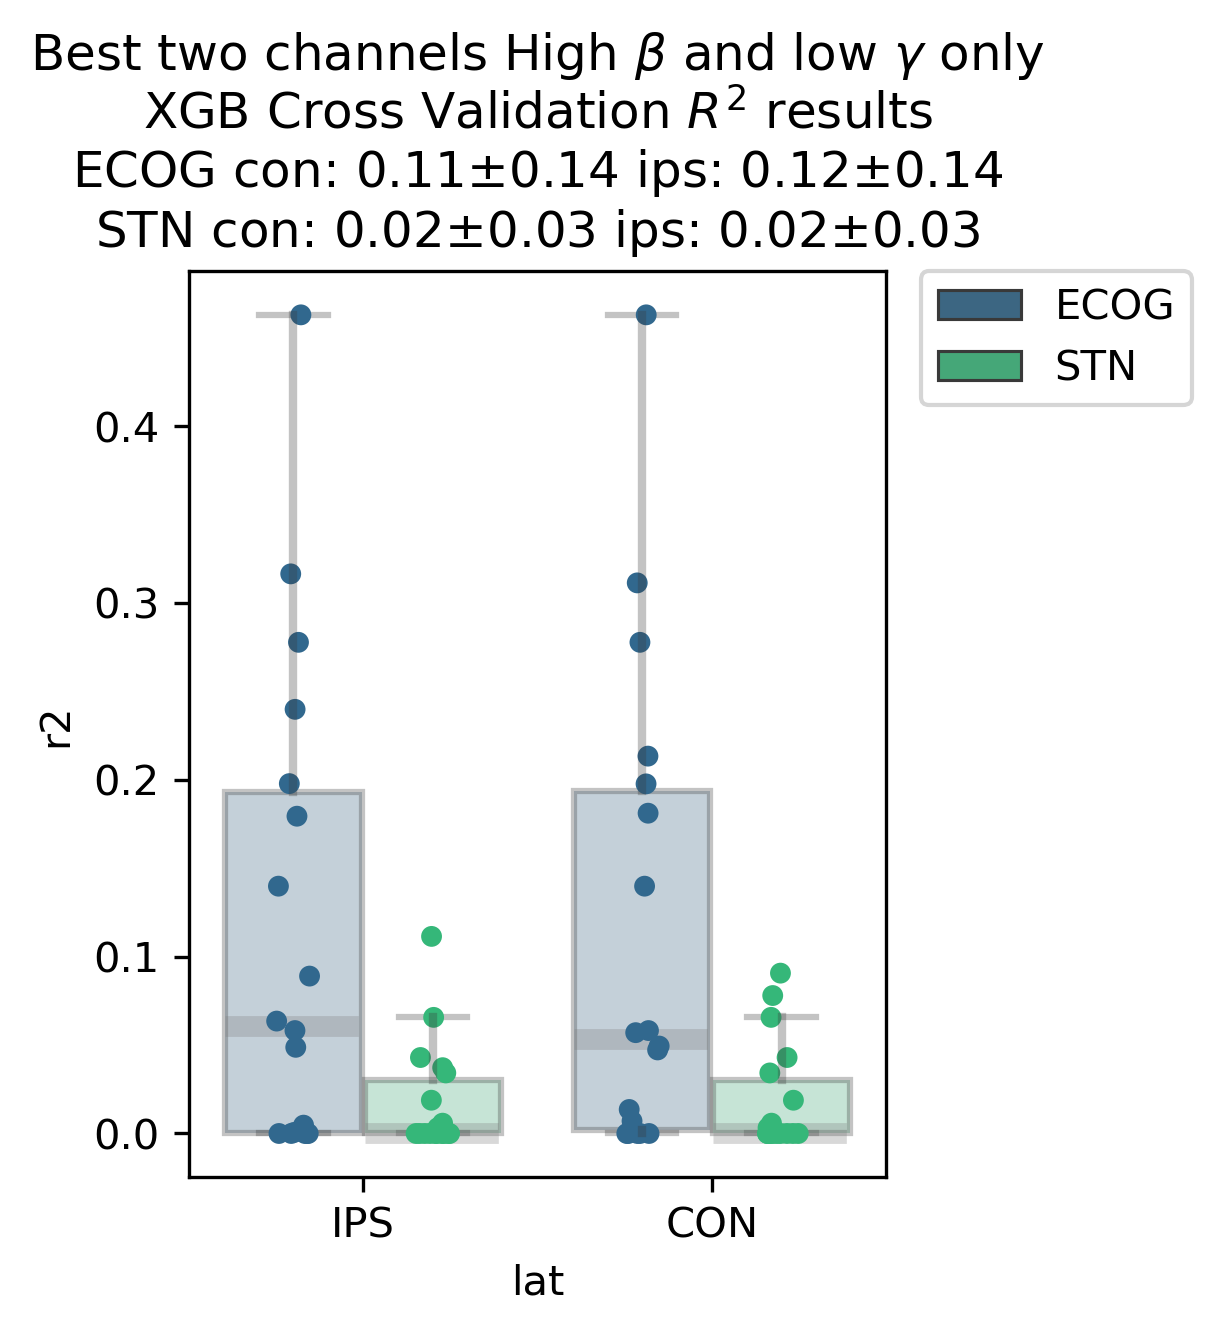

In [10]:
alpha_box = 0.3
plt.figure(figsize=(3,4), dpi=300)
sb.boxplot(x="lat", y="r2", hue="loc", order=["IPS", "CON"], data=df_res,
           palette="viridis", 
           showmeans=False, boxprops=dict(alpha=alpha_box), showcaps=True, showbox=True, 
           showfliers=False, notch=False,
           whiskerprops={'linewidth':2, "zorder":10, "alpha":alpha_box},
           capprops={"alpha":alpha_box},
           medianprops=dict(linestyle='-.', linewidth=5, color="gray", alpha=alpha_box))

    
ax = sb.stripplot(x="lat", y="r2", hue="loc", order=["IPS", "CON"], 
             data=df_res, palette="viridis", dodge=True, s=5)
#plt.xticks(rotation=90)

# When creating the legend, only use the first two elements
# to effectively remove the last two.
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Best two channels High "+r"$\beta$"+ " and low "+r"$\gamma$"+ " only"+\
          "\nXGB Cross Validation "+r"$R^2$"+" results\nECOG con: "+s_ECOG_CON+ " ips: "+s_ECOG_IPS+\
         "\nSTN con: "+s_STN_CON+ " ips: "+s_STN_IPS)

### now XGB all f bands 

In [12]:
# COMBINATION ECOG
model = linear_model.LinearRegression()
df_res = pd.DataFrame()
time_stamps = 5
NUM_extract = 2

for ch_USED in [["ECOG"], ["STN"]]:
    for f in range(len(os.listdir(PATH_))):
        sub_ = os.listdir(PATH_)[f][4:7]
        if sub_ not in ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']:
            continue
        print(sub_)
        for hem in ["LEFT", "RIGHT"]:
            with open(PATH_+ '\\'+ os.listdir(PATH_)[f], 'rb') as handle:
                run_ = pickle.load(handle)
                print(run_["ch_names"])
                if len([ch for ch in run_["ch_names"] if "STN" in ch]) == 0:
                    continue

                for label_idx, label in enumerate(run_["label_baseline_corrected"]):
                    
                    if run_["label_con_true"][label_idx] is True:
                        lat = "CON"
                    else:
                        lat = "IPS"
                    if ch_USED == ["ECOG"]:
                        loc_here = "ECOG"
                    elif ch_USED == ["STN"]:
                        loc_here = "STN"
                    else:
                        loc_here = "ECOG_STN"
                    
                    #ch_idx = get_idx(run_["ch_names"], ch_USED)
                    ch_idx = get_idx_best_N(hem, lat, sub_, loc_here, run_["ch_names"], NUM_extract = NUM_extract)

                    if len(ch_idx) == 0:
                        continue
                    print("PROCESS")
                    X_ = []
                    # the LABEL is not needed here... 
                    print(ch_idx)
                    print(run_["ch_names"])
                    start = True
                    for ch_idx_ in ch_idx:
                        X, y = append_time_dim(run_["rf_data_median"][:,ch_idx_,:], \
                                               run_["label_baseline_corrected"][0,:], \
                                               time_stamps=time_stamps)
                        if start == True:
                            X_ = X
                            start = False
                        else:
                            X_ = np.concatenate((X_, X), axis=1)

                    res_ = xgb.cv(xgb.XGBRegressor().get_params(), shuffle=False, dtrain=xgb.DMatrix(X_, label=y), 
                              feval=evalerror, nfold=3).iloc[-1]["test-r2-mean"]
                    if res_ < 0:
                        res_ = 0
                        
                    df_res = df_res.append({
                        "r2": res_,
                        #"ch_": ch_,
                        "sub": sub_,
                        "loc": loc_here,
                        "lat": lat
                    }, ignore_index=True)


000
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
000
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
000
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
000
['STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
Empty DataFrame
Columns: [ch_, hem, lat, loc, r2, sub]
Index: []
Empty DataFrame
Colu

             ch_   hem  lat   loc        r2  sub
25   ECOG_LEFT_0  LEFT  IPS  ECOG  0.044354  001
27   ECOG_LEFT_1  LEFT  IPS  ECOG  0.039572  001
29   ECOG_LEFT_2  LEFT  IPS  ECOG  0.119015  001
31   ECOG_LEFT_3  LEFT  IPS  ECOG  0.020518  001
33   ECOG_LEFT_4  LEFT  IPS  ECOG  0.074045  001
35   ECOG_LEFT_5  LEFT  IPS  ECOG  0.166431  001
37   ECOG_LEFT_6  LEFT  IPS  ECOG  0.196157  001
39   ECOG_LEFT_7  LEFT  IPS  ECOG  0.158656  001
41   ECOG_LEFT_8  LEFT  IPS  ECOG  0.100668  001
43   ECOG_LEFT_9  LEFT  IPS  ECOG  0.161383  001
45  ECOG_LEFT_10  LEFT  IPS  ECOG  0.147066  001
47  ECOG_LEFT_11  LEFT  IPS  ECOG  0.119299  001
49  ECOG_LEFT_12  LEFT  IPS  ECOG  0.000000  001
51  ECOG_LEFT_13  LEFT  IPS  ECOG  0.069895  001
53  ECOG_LEFT_14  LEFT  IPS  ECOG  0.041358  001
55  ECOG_LEFT_15  LEFT  IPS  ECOG  0.018451  001
57  ECOG_LEFT_16  LEFT  IPS  ECOG  0.051884  001
59  ECOG_LEFT_17  LEFT  IPS  ECOG  0.044626  001
61  ECOG_LEFT_18  LEFT  IPS  ECOG  0.025048  001
63  ECOG_LEFT_19  LE

['STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'ECOG_RIGHT_6', 'ECOG_RIGHT_7', 'ECOG_RIGHT_8', 'ECOG_RIGHT_9', 'ECOG_RIGHT_10', 'ECOG_RIGHT_11', 'ECOG_RIGHT_12', 'ECOG_RIGHT_13', 'ECOG_RIGHT_14', 'ECOG_RIGHT_15', 'ECOG_RIGHT_16', 'ECOG_RIGHT_17', 'ECOG_RIGHT_18', 'ECOG_RIGHT_19', 'ECOG_RIGHT_20', 'ECOG_RIGHT_21', 'ECOG_RIGHT_22', 'ECOG_RIGHT_23', 'ECOG_RIGHT_24', 'ECOG_RIGHT_25', 'ECOG_RIGHT_26', 'ECOG_RIGHT_27', 'MOV_RIGHT', 'MOV_LEFT']
               ch_    hem  lat   loc        r2  sub
86    ECOG_RIGHT_0  RIGHT  IPS  ECOG  0.012854  001
88    ECOG_RIGHT_1  RIGHT  IPS  ECOG  0.014349  001
90    ECOG_RIGHT_2  RIGHT  IPS  ECOG  0.049305  001
92    ECOG_RIGHT_3  RIGHT  IPS  ECOG  0.047369  001
94    ECOG_RIGHT_4  RIGHT  IPS  ECOG  0.021942  001
96    ECOG_RIGHT_5  RIGHT  IPS  ECOG  0.083808  001
98    ECOG_RIGHT_6  RIGHT  IPS  ECOG  0.050589  001
100   ECOG_RIGHT_7  RIGHT  IPS  ECOG  0.005915 

['STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'ECOG_RIGHT_6', 'ECOG_RIGHT_7', 'MOV_RIGHT', 'MOV_LEFT']
             ch_   hem  lat   loc        r2  sub
149  ECOG_LEFT_0  LEFT  IPS  ECOG  0.161563  004
151  ECOG_LEFT_1  LEFT  IPS  ECOG  0.077200  004
153  ECOG_LEFT_2  LEFT  IPS  ECOG  0.120292  004
155  ECOG_LEFT_3  LEFT  IPS  ECOG  0.091100  004
157  ECOG_LEFT_4  LEFT  IPS  ECOG  0.159328  004
159  ECOG_LEFT_5  LEFT  IPS  ECOG  0.086927  004
161  ECOG_LEFT_6  LEFT  IPS  ECOG  0.203582  004
163  ECOG_LEFT_7  LEFT  IPS  ECOG  0.037336  004
             ch_   hem  lat   loc        r2  sub
148  ECOG_LEFT_0  LEFT  CON  ECOG  0.033590  004
150  ECOG_LEFT_1  LEFT  CON  ECOG  0.014475  004
152  ECOG_LEFT_2  LEFT  CON  ECOG  0.024913  004
154  ECOG_LEFT_3  LEFT  CON  ECOG  0.013034  004
156  ECOG_LEFT_4  LEFT  CON  ECOG  0.013289  004
158  ECOG_LEFT_5  LEFT  CON  ECOG  0.011591  004
160  ECOG_LEFT_6 

006
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'ECOG_LEFT_8', 'ECOG_LEFT_9', 'ECOG_LEFT_10', 'ECOG_LEFT_11', 'ECOG_LEFT_12', 'ECOG_LEFT_13', 'ECOG_LEFT_14', 'ECOG_LEFT_15', 'ECOG_LEFT_16', 'ECOG_LEFT_17', 'ECOG_LEFT_18', 'ECOG_LEFT_19', 'ECOG_LEFT_20', 'ECOG_LEFT_21', 'ECOG_LEFT_22', 'ECOG_LEFT_23', 'ECOG_LEFT_24', 'ECOG_LEFT_25', 'ECOG_LEFT_26', 'ECOG_LEFT_27', 'ECOG_LEFT_28', 'ECOG_LEFT_29', 'ECOG_LEFT_30', 'ECOG_LEFT_31', 'ECOG_LEFT_32', 'ECOG_LEFT_33', 'ECOG_LEFT_34', 'MOV_RIGHT', 'MOV_LEFT']
              ch_   hem  lat   loc        r2  sub
236   ECOG_LEFT_0  LEFT  CON  ECOG  0.000000  006
238   ECOG_LEFT_1  LEFT  CON  ECOG  0.000000  006
240   ECOG_LEFT_2  LEFT  CON  ECOG  0.000000  006
242   ECOG_LEFT_3  LEFT  CON  ECOG  0.000000  006
244   ECOG_LEFT_4  LEFT  CON  ECOG  0.000000  006
..            ...   ...  ...   ...       ...  ...
452  ECOG_LEFT_31  LEFT  CON

              ch_   hem  lat   loc        r2  sub
237   ECOG_LEFT_0  LEFT  IPS  ECOG  0.000000  006
239   ECOG_LEFT_1  LEFT  IPS  ECOG  0.000000  006
241   ECOG_LEFT_2  LEFT  IPS  ECOG  0.000000  006
243   ECOG_LEFT_3  LEFT  IPS  ECOG  0.000000  006
245   ECOG_LEFT_4  LEFT  IPS  ECOG  0.000000  006
..            ...   ...  ...   ...       ...  ...
453  ECOG_LEFT_31  LEFT  IPS  ECOG  0.034273  006
455  ECOG_LEFT_32  LEFT  IPS  ECOG  0.000000  006
457  ECOG_LEFT_33  LEFT  IPS  ECOG  0.000000  006
459  ECOG_LEFT_34  LEFT  IPS  ECOG  0.010949  006
461  ECOG_LEFT_35  LEFT  IPS  ECOG  0.000000  006

[107 rows x 6 columns]
PROCESS
[28, 29]
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'ECOG_LEFT_8', 'ECOG_LEFT_9', 'ECOG_LEFT_10', 'ECOG_LEFT_11', 'ECOG_LEFT_12', 'ECOG_LEFT_13', 'ECOG_LEFT_14', 'ECOG_LEFT_15', 'ECOG_LEFT_16', 'ECOG_LEFT_17', 'ECOG_LEFT_18', 'ECOG_LEFT_19', 'ECOG_

['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'ECOG_LEFT_8', 'ECOG_LEFT_9', 'ECOG_LEFT_10', 'ECOG_LEFT_11', 'ECOG_LEFT_12', 'ECOG_LEFT_13', 'ECOG_LEFT_14', 'ECOG_LEFT_15', 'ECOG_LEFT_16', 'ECOG_LEFT_17', 'ECOG_LEFT_18', 'ECOG_LEFT_19', 'ECOG_LEFT_20', 'ECOG_LEFT_21', 'ECOG_LEFT_22', 'ECOG_LEFT_23', 'ECOG_LEFT_24', 'ECOG_LEFT_25', 'ECOG_LEFT_26', 'ECOG_LEFT_27', 'ECOG_LEFT_28', 'ECOG_LEFT_29', 'ECOG_LEFT_30', 'ECOG_LEFT_31', 'ECOG_LEFT_32', 'ECOG_LEFT_33', 'ECOG_LEFT_34', 'ECOG_LEFT_35', 'MOV_RIGHT', 'MOV_LEFT']
               ch_    hem  lat   loc        r2  sub
469   ECOG_RIGHT_0  RIGHT  CON  ECOG  0.000000  006
471   ECOG_RIGHT_1  RIGHT  CON  ECOG  0.000000  006
473   ECOG_RIGHT_2  RIGHT  CON  ECOG  0.000000  006
475   ECOG_RIGHT_3  RIGHT  CON  ECOG  0.000000  006
477   ECOG_RIGHT_4  RIGHT  CON  ECOG  0.000000  006
479   ECOG_RIGHT_5  RIGHT  CON  ECOG  0.000000  006
48

['STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'ECOG_RIGHT_6', 'ECOG_RIGHT_7', 'ECOG_RIGHT_8', 'ECOG_RIGHT_9', 'ECOG_RIGHT_10', 'ECOG_RIGHT_11', 'ECOG_RIGHT_12', 'ECOG_RIGHT_13', 'ECOG_RIGHT_14', 'ECOG_RIGHT_15', 'ECOG_RIGHT_16', 'ECOG_RIGHT_17', 'ECOG_RIGHT_18', 'ECOG_RIGHT_19', 'ECOG_RIGHT_20', 'ECOG_RIGHT_21', 'ECOG_RIGHT_22', 'ECOG_RIGHT_23', 'ECOG_RIGHT_24', 'ECOG_RIGHT_25', 'ECOG_RIGHT_26', 'ECOG_RIGHT_27', 'ECOG_RIGHT_28', 'ECOG_RIGHT_29', 'ECOG_RIGHT_30', 'ECOG_RIGHT_31', 'ECOG_RIGHT_32', 'ECOG_RIGHT_33', 'ECOG_RIGHT_34', 'ECOG_RIGHT_35', 'MOV_RIGHT', 'MOV_LEFT']
               ch_    hem  lat   loc        r2  sub
468   ECOG_RIGHT_0  RIGHT  IPS  ECOG  0.000000  006
470   ECOG_RIGHT_1  RIGHT  IPS  ECOG  0.000000  006
472   ECOG_RIGHT_2  RIGHT  IPS  ECOG  0.000000  006
474   ECOG_RIGHT_3  RIGHT  IPS  ECOG  0.000000  006
476   ECOG_RIGHT_4  RIGHT  IPS  ECOG  0.000000  006
478   ECOG_RIGH

             ch_   hem  lat   loc   r2  sub
565  ECOG_LEFT_0  LEFT  IPS  ECOG  0.0  008
567  ECOG_LEFT_1  LEFT  IPS  ECOG  0.0  008
569  ECOG_LEFT_2  LEFT  IPS  ECOG  0.0  008
571  ECOG_LEFT_3  LEFT  IPS  ECOG  0.0  008
573  ECOG_LEFT_4  LEFT  IPS  ECOG  0.0  008
575  ECOG_LEFT_5  LEFT  IPS  ECOG  0.0  008
PROCESS
[3, 4]
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
Empty DataFrame
Columns: [ch_, hem, lat, loc, r2, sub]
Index: []
Empty DataFrame
Columns: [ch_, hem, lat, loc, r2, sub]
Index: []
008
['ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
['ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LE

              ch_    hem  lat   loc        r2  sub
619  ECOG_RIGHT_0  RIGHT  CON  ECOG  0.097979  010
621  ECOG_RIGHT_1  RIGHT  CON  ECOG  0.000000  010
623  ECOG_RIGHT_2  RIGHT  CON  ECOG  0.000000  010
625  ECOG_RIGHT_3  RIGHT  CON  ECOG  0.000000  010
627  ECOG_RIGHT_4  RIGHT  CON  ECOG  0.000000  010
629  ECOG_RIGHT_5  RIGHT  CON  ECOG  0.000000  010
PROCESS
[3, 4]
['STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
013
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
             ch_   hem  lat   loc        r2  sub
636  ECOG_LEFT_0  LEFT  CON  ECOG  0.069603  013
638  ECOG_LEFT_1  LEFT  CON  ECOG  0.044267  013
640  ECOG_LEFT_2  LEFT  CON  ECOG  0.088484  013
642  ECOG_LEFT_3  LEFT  CON  ECOG  0.142148  013
644  ECOG_LEFT_4  LEFT  CON  ECOG  0.103122  013
646  

['ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'ECOG_LEFT_8', 'ECOG_LEFT_9', 'ECOG_LEFT_10', 'ECOG_LEFT_11', 'ECOG_LEFT_12', 'ECOG_LEFT_13', 'ECOG_LEFT_14', 'ECOG_LEFT_15', 'ECOG_LEFT_16', 'ECOG_LEFT_17', 'ECOG_LEFT_18', 'ECOG_LEFT_19', 'ECOG_LEFT_20', 'ECOG_LEFT_21', 'ECOG_LEFT_22', 'ECOG_LEFT_23', 'ECOG_LEFT_24', 'ECOG_LEFT_25', 'ECOG_LEFT_26', 'ECOG_LEFT_27', 'MOV_RIGHT', 'MOV_LEFT']
001
['ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'ECOG_LEFT_8', 'ECOG_LEFT_9', 'ECOG_LEFT_10', 'ECOG_LEFT_11', 'ECOG_LEFT_12', 'ECOG_LEFT_13', 'ECOG_LEFT_14', 'ECOG_LEFT_15', 'ECOG_LEFT_16', 'ECOG_LEFT_17', 'ECOG_LEFT_18', 'ECOG_LEFT_19', 'ECOG_LEFT_20', 'ECOG_LEFT_21', 'ECOG_LEFT_22', 'ECOG_LEFT_23', 'ECOG_LEFT_24', 'ECOG_LEFT_25', 'ECOG_LEFT_26', 'ECOG_LEFT_27', 'MOV_RIGHT', 'MOV_LEFT']
['ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_L

['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'ECOG_RIGHT_6', 'ECOG_RIGHT_7', 'ECOG_RIGHT_8', 'ECOG_RIGHT_9', 'ECOG_RIGHT_10', 'ECOG_RIGHT_11', 'ECOG_RIGHT_12', 'ECOG_RIGHT_13', 'ECOG_RIGHT_14', 'ECOG_RIGHT_15', 'ECOG_RIGHT_16', 'ECOG_RIGHT_17', 'ECOG_RIGHT_18', 'ECOG_RIGHT_19', 'ECOG_RIGHT_20', 'ECOG_RIGHT_21', 'ECOG_RIGHT_22', 'ECOG_RIGHT_23', 'ECOG_RIGHT_24', 'ECOG_RIGHT_25', 'ECOG_RIGHT_26', 'ECOG_RIGHT_27', 'MOV_RIGHT', 'MOV_LEFT']
004
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'MOV_RIGHT', 'MOV_LEFT']
            ch_   hem  lat  loc        r2  sub
142  STN_LEFT_0  LEFT  CON  STN  0.018564  004
144  STN_LEFT_1  LEFT  CON  STN  0.028690  004
146  STN_LEFT_2  LEFT  CON  STN  0.010296  004
PROCESS
[0, 1]
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT

            ch_   hem  lat  loc        r2  sub
231  STN_LEFT_0  LEFT  IPS  STN  0.000000  006
233  STN_LEFT_1  LEFT  IPS  STN  0.059231  006
235  STN_LEFT_2  LEFT  IPS  STN  0.003577  006
307  STN_LEFT_0  LEFT  IPS  STN  0.012663  006
309  STN_LEFT_1  LEFT  IPS  STN  0.000000  006
311  STN_LEFT_2  LEFT  IPS  STN  0.000000  006
385  STN_LEFT_0  LEFT  IPS  STN  0.000000  006
387  STN_LEFT_1  LEFT  IPS  STN  0.000000  006
389  STN_LEFT_2  LEFT  IPS  STN  0.000000  006
PROCESS
[0, 1]
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'ECOG_LEFT_8', 'ECOG_LEFT_9', 'ECOG_LEFT_10', 'ECOG_LEFT_11', 'ECOG_LEFT_12', 'ECOG_LEFT_13', 'ECOG_LEFT_14', 'ECOG_LEFT_15', 'ECOG_LEFT_16', 'ECOG_LEFT_17', 'ECOG_LEFT_18', 'ECOG_LEFT_19', 'ECOG_LEFT_20', 'ECOG_LEFT_21', 'ECOG_LEFT_22', 'ECOG_LEFT_23', 'ECOG_LEFT_24', 'ECOG_LEFT_25', 'ECOG_LEFT_26', 'ECOG_LEFT_27', 'ECOG_LEFT_28', 'ECOG_LEFT_29', 'E

['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'ECOG_LEFT_8', 'ECOG_LEFT_9', 'ECOG_LEFT_10', 'ECOG_LEFT_11', 'ECOG_LEFT_12', 'ECOG_LEFT_13', 'ECOG_LEFT_14', 'ECOG_LEFT_15', 'ECOG_LEFT_16', 'ECOG_LEFT_17', 'ECOG_LEFT_18', 'ECOG_LEFT_19', 'ECOG_LEFT_20', 'ECOG_LEFT_21', 'ECOG_LEFT_22', 'ECOG_LEFT_23', 'ECOG_LEFT_24', 'ECOG_LEFT_25', 'ECOG_LEFT_26', 'ECOG_LEFT_27', 'ECOG_LEFT_28', 'ECOG_LEFT_29', 'ECOG_LEFT_30', 'ECOG_LEFT_31', 'ECOG_LEFT_32', 'ECOG_LEFT_33', 'ECOG_LEFT_34', 'ECOG_LEFT_35', 'MOV_RIGHT', 'MOV_LEFT']
             ch_    hem  lat  loc        r2  sub
463  STN_RIGHT_0  RIGHT  CON  STN  0.000000  006
465  STN_RIGHT_1  RIGHT  CON  STN  0.081203  006
467  STN_RIGHT_2  RIGHT  CON  STN  0.000000  006
             ch_    hem  lat  loc        r2  sub
462  STN_RIGHT_0  RIGHT  IPS  STN  0.000000  006
464  STN_RIGHT_1  RIGHT  IPS  STN  0.027293  006
466  STN_RIGHT_2  RIGHT

            ch_   hem  lat  loc       r2  sub
541  STN_LEFT_0  LEFT  IPS  STN  0.01028  007
543  STN_LEFT_1  LEFT  IPS  STN  0.00000  007
545  STN_LEFT_2  LEFT  IPS  STN  0.00000  007
PROCESS
[0, 1]
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
Empty DataFrame
Columns: [ch_, hem, lat, loc, r2, sub]
Index: []
Empty DataFrame
Columns: [ch_, hem, lat, loc, r2, sub]
Index: []
008
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
            ch_   hem  lat  loc   r2  sub
558  STN_LEFT_0  LEFT  CON  STN  0.0  008
560  STN_LEFT_1  LEFT  CON  STN  0.0  008
562  STN_LEFT_2  LEFT  CON  STN  0.0  008
PROCESS
[0, 1]
['STN_LEFT

             ch_    hem  lat  loc        r2  sub
613  STN_RIGHT_0  RIGHT  CON  STN  0.000000  010
615  STN_RIGHT_1  RIGHT  CON  STN  0.000000  010
617  STN_RIGHT_2  RIGHT  CON  STN  0.002052  010
PROCESS
[0, 2]
['STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
013
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
            ch_   hem  lat  loc   r2  sub
630  STN_LEFT_0  LEFT  CON  STN  0.0  013
632  STN_LEFT_1  LEFT  CON  STN  0.0  013
634  STN_LEFT_2  LEFT  CON  STN  0.0  013
PROCESS
[0, 1]
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
            ch_   hem  lat  loc   r2  sub
631  STN_LEFT_0  LEFT  IPS  STN  0.0  013
633  STN_LEFT_1  LEFT  IPS  STN  0.

In [ ]:
X_.shape

In [13]:
s_ECOG_CON = str(np.round(df_res[(df_res["lat"] == "CON") & (df_res["loc"] == "ECOG")]["r2"].mean(), 2))+\
                 r"$\pm$"+str(np.round(df_res[(df_res["lat"] == "CON") & (df_res["loc"] == "ECOG")]["r2"].std(),2))
s_ECOG_IPS = str(np.round(df_res[(df_res["lat"] == "IPS") & (df_res["loc"] == "ECOG")]["r2"].mean(), 2))+\
                 r"$\pm$"+str(np.round(df_res[(df_res["lat"] == "IPS") & (df_res["loc"] == "ECOG")]["r2"].std(),2))
s_STN_CON = str(np.round(df_res[(df_res["lat"] == "CON") & (df_res["loc"] == "STN")]["r2"].mean(), 2))+\
                 r"$\pm$"+str(np.round(df_res[(df_res["lat"] == "CON") & (df_res["loc"] == "STN")]["r2"].std(),2))
s_STN_IPS = str(np.round(df_res[(df_res["lat"] == "IPS") & (df_res["loc"] == "STN")]["r2"].mean(), 2))+\
                 r"$\pm$"+str(np.round(df_res[(df_res["lat"] == "IPS") & (df_res["loc"] == "STN")]["r2"].std(),2))           

Text(0.5, 1.0, 'Best two channels all f bands\nXGB Cross Validation $R^2$ results\nECOG con: 0.19$\\pm$0.2 ips: 0.16$\\pm$0.19\nSTN con: 0.03$\\pm$0.06 ips: 0.03$\\pm$0.06')

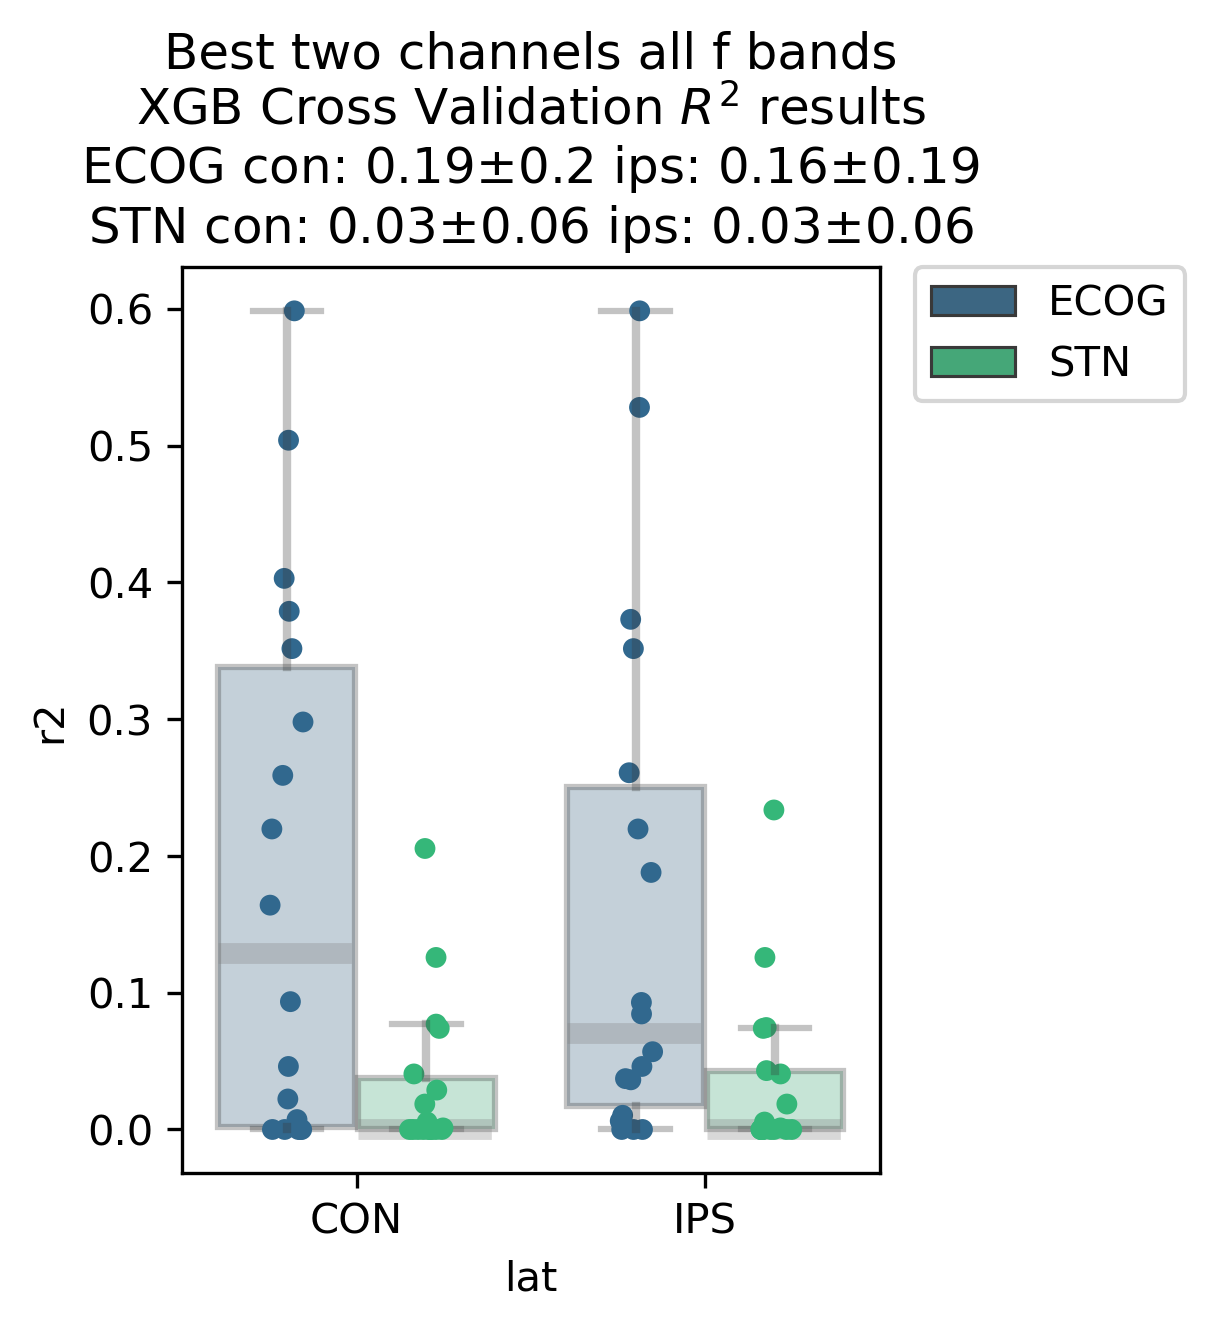

In [14]:
alpha_box = 0.3
plt.figure(figsize=(3,4), dpi=300)
sb.boxplot(x="lat", y="r2", hue="loc", order=["CON", "IPS"], data=df_res,
           palette="viridis", 
           showmeans=False, boxprops=dict(alpha=alpha_box), showcaps=True, showbox=True, 
           showfliers=False, notch=False,
           whiskerprops={'linewidth':2, "zorder":10, "alpha":alpha_box},
           capprops={"alpha":alpha_box},
           medianprops=dict(linestyle='-.', linewidth=5, color="gray", alpha=alpha_box))

    
ax = sb.stripplot(x="lat", y="r2", hue="loc", order=["CON", "IPS"], 
             data=df_res, palette="viridis", dodge=True, s=5)
#plt.xticks(rotation=90)

# When creating the legend, only use the first two elements
# to effectively remove the last two.
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Best two channels all f bands"+\
          "\nXGB Cross Validation "+r"$R^2$"+" results\nECOG con: "+s_ECOG_CON+ " ips: "+s_ECOG_IPS+\
         "\nSTN con: "+s_STN_CON+ " ips: "+s_STN_IPS)

In [ ]:
# for a combined plot of 1. best ECOG and best STN channel 2. all ECOG + STN 3. all ECOG 4. all STN 
# 

### XGB all f bands for three best channels 

In [15]:
# COMBINATION ECOG
model = linear_model.LinearRegression()
df_res = pd.DataFrame()
time_stamps = 5
NUM_extract = 3

for ch_USED in [["ECOG"], ["STN"]]:
    for f in range(len(os.listdir(PATH_))):
        sub_ = os.listdir(PATH_)[f][4:7]
        if sub_ not in ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']:
            continue
        print(sub_)
        for hem in ["LEFT", "RIGHT"]:
            with open(PATH_+ '\\'+ os.listdir(PATH_)[f], 'rb') as handle:
                run_ = pickle.load(handle)
                print(run_["ch_names"])
                if len([ch for ch in run_["ch_names"] if "STN" in ch]) == 0:
                    continue

                for label_idx, label in enumerate(run_["label_baseline_corrected"]):
                    
                    if run_["label_con_true"][label_idx] is True:
                        lat = "CON"
                    else:
                        lat = "IPS"
                    if ch_USED == ["ECOG"]:
                        loc_here = "ECOG"
                    elif ch_USED == ["STN"]:
                        loc_here = "STN"
                    else:
                        loc_here = "ECOG_STN"
                    
                    #ch_idx = get_idx(run_["ch_names"], ch_USED)
                    ch_idx = get_idx_best_N(hem, lat, sub_, loc_here, run_["ch_names"], NUM_extract = NUM_extract)

                    if len(ch_idx) == 0:
                        continue
                    print("PROCESS")
                    X_ = []
                    # the LABEL is not needed here... 
                    print(ch_idx)
                    print(run_["ch_names"])
                    start = True
                    for ch_idx_ in ch_idx:
                        X, y = append_time_dim(run_["rf_data_median"][:,ch_idx_,:], \
                                               run_["label_baseline_corrected"][0,:], \
                                               time_stamps=time_stamps)
                        if start == True:
                            X_ = X
                            start = False
                        else:
                            X_ = np.concatenate((X_, X), axis=1)

                    res_ = xgb.cv(xgb.XGBRegressor().get_params(), shuffle=False, dtrain=xgb.DMatrix(X_, label=y), 
                              feval=evalerror, nfold=3).iloc[-1]["test-r2-mean"]
                    if res_ < 0:
                        res_ = 0
                        
                    df_res = df_res.append({
                        "r2": res_,
                        #"ch_": ch_,
                        "sub": sub_,
                        "loc": loc_here,
                        "lat": lat
                    }, ignore_index=True)


000
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
000
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
000
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
000
['STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
Empty DataFrame
Columns: [ch_, hem, lat, loc, r2, sub]
Index: []
Empty DataFrame
Colu

             ch_   hem  lat   loc        r2  sub
25   ECOG_LEFT_0  LEFT  IPS  ECOG  0.044354  001
27   ECOG_LEFT_1  LEFT  IPS  ECOG  0.039572  001
29   ECOG_LEFT_2  LEFT  IPS  ECOG  0.119015  001
31   ECOG_LEFT_3  LEFT  IPS  ECOG  0.020518  001
33   ECOG_LEFT_4  LEFT  IPS  ECOG  0.074045  001
35   ECOG_LEFT_5  LEFT  IPS  ECOG  0.166431  001
37   ECOG_LEFT_6  LEFT  IPS  ECOG  0.196157  001
39   ECOG_LEFT_7  LEFT  IPS  ECOG  0.158656  001
41   ECOG_LEFT_8  LEFT  IPS  ECOG  0.100668  001
43   ECOG_LEFT_9  LEFT  IPS  ECOG  0.161383  001
45  ECOG_LEFT_10  LEFT  IPS  ECOG  0.147066  001
47  ECOG_LEFT_11  LEFT  IPS  ECOG  0.119299  001
49  ECOG_LEFT_12  LEFT  IPS  ECOG  0.000000  001
51  ECOG_LEFT_13  LEFT  IPS  ECOG  0.069895  001
53  ECOG_LEFT_14  LEFT  IPS  ECOG  0.041358  001
55  ECOG_LEFT_15  LEFT  IPS  ECOG  0.018451  001
57  ECOG_LEFT_16  LEFT  IPS  ECOG  0.051884  001
59  ECOG_LEFT_17  LEFT  IPS  ECOG  0.044626  001
61  ECOG_LEFT_18  LEFT  IPS  ECOG  0.025048  001
63  ECOG_LEFT_19  LE

['STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'ECOG_RIGHT_6', 'ECOG_RIGHT_7', 'ECOG_RIGHT_8', 'ECOG_RIGHT_9', 'ECOG_RIGHT_10', 'ECOG_RIGHT_11', 'ECOG_RIGHT_12', 'ECOG_RIGHT_13', 'ECOG_RIGHT_14', 'ECOG_RIGHT_15', 'ECOG_RIGHT_16', 'ECOG_RIGHT_17', 'ECOG_RIGHT_18', 'ECOG_RIGHT_19', 'ECOG_RIGHT_20', 'ECOG_RIGHT_21', 'ECOG_RIGHT_22', 'ECOG_RIGHT_23', 'ECOG_RIGHT_24', 'ECOG_RIGHT_25', 'ECOG_RIGHT_26', 'ECOG_RIGHT_27', 'MOV_RIGHT', 'MOV_LEFT']
               ch_    hem  lat   loc        r2  sub
86    ECOG_RIGHT_0  RIGHT  IPS  ECOG  0.012854  001
88    ECOG_RIGHT_1  RIGHT  IPS  ECOG  0.014349  001
90    ECOG_RIGHT_2  RIGHT  IPS  ECOG  0.049305  001
92    ECOG_RIGHT_3  RIGHT  IPS  ECOG  0.047369  001
94    ECOG_RIGHT_4  RIGHT  IPS  ECOG  0.021942  001
96    ECOG_RIGHT_5  RIGHT  IPS  ECOG  0.083808  001
98    ECOG_RIGHT_6  RIGHT  IPS  ECOG  0.050589  001
100   ECOG_RIGHT_7  RIGHT  IPS  ECOG  0.005915 

['STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'ECOG_RIGHT_6', 'ECOG_RIGHT_7', 'MOV_RIGHT', 'MOV_LEFT']
             ch_   hem  lat   loc        r2  sub
149  ECOG_LEFT_0  LEFT  IPS  ECOG  0.161563  004
151  ECOG_LEFT_1  LEFT  IPS  ECOG  0.077200  004
153  ECOG_LEFT_2  LEFT  IPS  ECOG  0.120292  004
155  ECOG_LEFT_3  LEFT  IPS  ECOG  0.091100  004
157  ECOG_LEFT_4  LEFT  IPS  ECOG  0.159328  004
159  ECOG_LEFT_5  LEFT  IPS  ECOG  0.086927  004
161  ECOG_LEFT_6  LEFT  IPS  ECOG  0.203582  004
163  ECOG_LEFT_7  LEFT  IPS  ECOG  0.037336  004
             ch_   hem  lat   loc        r2  sub
148  ECOG_LEFT_0  LEFT  CON  ECOG  0.033590  004
150  ECOG_LEFT_1  LEFT  CON  ECOG  0.014475  004
152  ECOG_LEFT_2  LEFT  CON  ECOG  0.024913  004
154  ECOG_LEFT_3  LEFT  CON  ECOG  0.013034  004
156  ECOG_LEFT_4  LEFT  CON  ECOG  0.013289  004
158  ECOG_LEFT_5  LEFT  CON  ECOG  0.011591  004
160  ECOG_LEFT_6 

006
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'ECOG_LEFT_8', 'ECOG_LEFT_9', 'ECOG_LEFT_10', 'ECOG_LEFT_11', 'ECOG_LEFT_12', 'ECOG_LEFT_13', 'ECOG_LEFT_14', 'ECOG_LEFT_15', 'ECOG_LEFT_16', 'ECOG_LEFT_17', 'ECOG_LEFT_18', 'ECOG_LEFT_19', 'ECOG_LEFT_20', 'ECOG_LEFT_21', 'ECOG_LEFT_22', 'ECOG_LEFT_23', 'ECOG_LEFT_24', 'ECOG_LEFT_25', 'ECOG_LEFT_26', 'ECOG_LEFT_27', 'ECOG_LEFT_28', 'ECOG_LEFT_29', 'ECOG_LEFT_30', 'ECOG_LEFT_31', 'ECOG_LEFT_32', 'ECOG_LEFT_33', 'ECOG_LEFT_34', 'MOV_RIGHT', 'MOV_LEFT']
              ch_   hem  lat   loc        r2  sub
236   ECOG_LEFT_0  LEFT  CON  ECOG  0.000000  006
238   ECOG_LEFT_1  LEFT  CON  ECOG  0.000000  006
240   ECOG_LEFT_2  LEFT  CON  ECOG  0.000000  006
242   ECOG_LEFT_3  LEFT  CON  ECOG  0.000000  006
244   ECOG_LEFT_4  LEFT  CON  ECOG  0.000000  006
..            ...   ...  ...   ...       ...  ...
452  ECOG_LEFT_31  LEFT  CON

              ch_   hem  lat   loc        r2  sub
237   ECOG_LEFT_0  LEFT  IPS  ECOG  0.000000  006
239   ECOG_LEFT_1  LEFT  IPS  ECOG  0.000000  006
241   ECOG_LEFT_2  LEFT  IPS  ECOG  0.000000  006
243   ECOG_LEFT_3  LEFT  IPS  ECOG  0.000000  006
245   ECOG_LEFT_4  LEFT  IPS  ECOG  0.000000  006
..            ...   ...  ...   ...       ...  ...
453  ECOG_LEFT_31  LEFT  IPS  ECOG  0.034273  006
455  ECOG_LEFT_32  LEFT  IPS  ECOG  0.000000  006
457  ECOG_LEFT_33  LEFT  IPS  ECOG  0.000000  006
459  ECOG_LEFT_34  LEFT  IPS  ECOG  0.010949  006
461  ECOG_LEFT_35  LEFT  IPS  ECOG  0.000000  006

[107 rows x 6 columns]
PROCESS
[27, 28, 29]
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'ECOG_LEFT_8', 'ECOG_LEFT_9', 'ECOG_LEFT_10', 'ECOG_LEFT_11', 'ECOG_LEFT_12', 'ECOG_LEFT_13', 'ECOG_LEFT_14', 'ECOG_LEFT_15', 'ECOG_LEFT_16', 'ECOG_LEFT_17', 'ECOG_LEFT_18', 'ECOG_LEFT_19', 'E

['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'ECOG_LEFT_8', 'ECOG_LEFT_9', 'ECOG_LEFT_10', 'ECOG_LEFT_11', 'ECOG_LEFT_12', 'ECOG_LEFT_13', 'ECOG_LEFT_14', 'ECOG_LEFT_15', 'ECOG_LEFT_16', 'ECOG_LEFT_17', 'ECOG_LEFT_18', 'ECOG_LEFT_19', 'ECOG_LEFT_20', 'ECOG_LEFT_21', 'ECOG_LEFT_22', 'ECOG_LEFT_23', 'ECOG_LEFT_24', 'ECOG_LEFT_25', 'ECOG_LEFT_26', 'ECOG_LEFT_27', 'ECOG_LEFT_28', 'ECOG_LEFT_29', 'ECOG_LEFT_30', 'ECOG_LEFT_31', 'ECOG_LEFT_32', 'ECOG_LEFT_33', 'ECOG_LEFT_34', 'ECOG_LEFT_35', 'MOV_RIGHT', 'MOV_LEFT']
               ch_    hem  lat   loc        r2  sub
469   ECOG_RIGHT_0  RIGHT  CON  ECOG  0.000000  006
471   ECOG_RIGHT_1  RIGHT  CON  ECOG  0.000000  006
473   ECOG_RIGHT_2  RIGHT  CON  ECOG  0.000000  006
475   ECOG_RIGHT_3  RIGHT  CON  ECOG  0.000000  006
477   ECOG_RIGHT_4  RIGHT  CON  ECOG  0.000000  006
479   ECOG_RIGHT_5  RIGHT  CON  ECOG  0.000000  006
48

['STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'ECOG_RIGHT_6', 'ECOG_RIGHT_7', 'ECOG_RIGHT_8', 'ECOG_RIGHT_9', 'ECOG_RIGHT_10', 'ECOG_RIGHT_11', 'ECOG_RIGHT_12', 'ECOG_RIGHT_13', 'ECOG_RIGHT_14', 'ECOG_RIGHT_15', 'ECOG_RIGHT_16', 'ECOG_RIGHT_17', 'ECOG_RIGHT_18', 'ECOG_RIGHT_19', 'ECOG_RIGHT_20', 'ECOG_RIGHT_21', 'ECOG_RIGHT_22', 'ECOG_RIGHT_23', 'ECOG_RIGHT_24', 'ECOG_RIGHT_25', 'ECOG_RIGHT_26', 'ECOG_RIGHT_27', 'ECOG_RIGHT_28', 'ECOG_RIGHT_29', 'ECOG_RIGHT_30', 'ECOG_RIGHT_31', 'ECOG_RIGHT_32', 'ECOG_RIGHT_33', 'ECOG_RIGHT_34', 'ECOG_RIGHT_35', 'MOV_RIGHT', 'MOV_LEFT']
               ch_    hem  lat   loc        r2  sub
468   ECOG_RIGHT_0  RIGHT  IPS  ECOG  0.000000  006
470   ECOG_RIGHT_1  RIGHT  IPS  ECOG  0.000000  006
472   ECOG_RIGHT_2  RIGHT  IPS  ECOG  0.000000  006
474   ECOG_RIGHT_3  RIGHT  IPS  ECOG  0.000000  006
476   ECOG_RIGHT_4  RIGHT  IPS  ECOG  0.000000  006
478   ECOG_RIGH

             ch_   hem  lat   loc   r2  sub
565  ECOG_LEFT_0  LEFT  IPS  ECOG  0.0  008
567  ECOG_LEFT_1  LEFT  IPS  ECOG  0.0  008
569  ECOG_LEFT_2  LEFT  IPS  ECOG  0.0  008
571  ECOG_LEFT_3  LEFT  IPS  ECOG  0.0  008
573  ECOG_LEFT_4  LEFT  IPS  ECOG  0.0  008
575  ECOG_LEFT_5  LEFT  IPS  ECOG  0.0  008
PROCESS
[3, 4, 5]
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
Empty DataFrame
Columns: [ch_, hem, lat, loc, r2, sub]
Index: []
Empty DataFrame
Columns: [ch_, hem, lat, loc, r2, sub]
Index: []
008
['ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
['ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV

              ch_    hem  lat   loc        r2  sub
619  ECOG_RIGHT_0  RIGHT  CON  ECOG  0.097979  010
621  ECOG_RIGHT_1  RIGHT  CON  ECOG  0.000000  010
623  ECOG_RIGHT_2  RIGHT  CON  ECOG  0.000000  010
625  ECOG_RIGHT_3  RIGHT  CON  ECOG  0.000000  010
627  ECOG_RIGHT_4  RIGHT  CON  ECOG  0.000000  010
629  ECOG_RIGHT_5  RIGHT  CON  ECOG  0.000000  010
PROCESS
[3, 4, 5]
['STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
013
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
             ch_   hem  lat   loc        r2  sub
636  ECOG_LEFT_0  LEFT  CON  ECOG  0.069603  013
638  ECOG_LEFT_1  LEFT  CON  ECOG  0.044267  013
640  ECOG_LEFT_2  LEFT  CON  ECOG  0.088484  013
642  ECOG_LEFT_3  LEFT  CON  ECOG  0.142148  013
644  ECOG_LEFT_4  LEFT  CON  ECOG  0.103122  013
64

['ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'ECOG_LEFT_8', 'ECOG_LEFT_9', 'ECOG_LEFT_10', 'ECOG_LEFT_11', 'ECOG_LEFT_12', 'ECOG_LEFT_13', 'ECOG_LEFT_14', 'ECOG_LEFT_15', 'ECOG_LEFT_16', 'ECOG_LEFT_17', 'ECOG_LEFT_18', 'ECOG_LEFT_19', 'ECOG_LEFT_20', 'ECOG_LEFT_21', 'ECOG_LEFT_22', 'ECOG_LEFT_23', 'ECOG_LEFT_24', 'ECOG_LEFT_25', 'ECOG_LEFT_26', 'ECOG_LEFT_27', 'MOV_RIGHT', 'MOV_LEFT']
001
['ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'ECOG_LEFT_8', 'ECOG_LEFT_9', 'ECOG_LEFT_10', 'ECOG_LEFT_11', 'ECOG_LEFT_12', 'ECOG_LEFT_13', 'ECOG_LEFT_14', 'ECOG_LEFT_15', 'ECOG_LEFT_16', 'ECOG_LEFT_17', 'ECOG_LEFT_18', 'ECOG_LEFT_19', 'ECOG_LEFT_20', 'ECOG_LEFT_21', 'ECOG_LEFT_22', 'ECOG_LEFT_23', 'ECOG_LEFT_24', 'ECOG_LEFT_25', 'ECOG_LEFT_26', 'ECOG_LEFT_27', 'MOV_RIGHT', 'MOV_LEFT']
['ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_L

['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'MOV_RIGHT', 'MOV_LEFT']
            ch_   hem  lat  loc        r2  sub
142  STN_LEFT_0  LEFT  CON  STN  0.018564  004
144  STN_LEFT_1  LEFT  CON  STN  0.028690  004
146  STN_LEFT_2  LEFT  CON  STN  0.010296  004
PROCESS
[0, 1, 2]
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'MOV_RIGHT', 'MOV_LEFT']
            ch_   hem  lat  loc        r2  sub
143  STN_LEFT_0  LEFT  IPS  STN  0.005697  004
145  STN_LEFT_1  LEFT  IPS  STN  0.035368  004
147  STN_LEFT_2  LEFT  IPS  STN  0.079431  004
PROCESS
[0, 1, 2]
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'MOV_RIGHT', 'MOV_LEFT']
['STN_LEFT_0', 'STN_LEFT

            ch_   hem  lat  loc        r2  sub
231  STN_LEFT_0  LEFT  IPS  STN  0.000000  006
233  STN_LEFT_1  LEFT  IPS  STN  0.059231  006
235  STN_LEFT_2  LEFT  IPS  STN  0.003577  006
307  STN_LEFT_0  LEFT  IPS  STN  0.012663  006
309  STN_LEFT_1  LEFT  IPS  STN  0.000000  006
311  STN_LEFT_2  LEFT  IPS  STN  0.000000  006
385  STN_LEFT_0  LEFT  IPS  STN  0.000000  006
387  STN_LEFT_1  LEFT  IPS  STN  0.000000  006
389  STN_LEFT_2  LEFT  IPS  STN  0.000000  006
PROCESS
[0, 1, 2]
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'ECOG_LEFT_8', 'ECOG_LEFT_9', 'ECOG_LEFT_10', 'ECOG_LEFT_11', 'ECOG_LEFT_12', 'ECOG_LEFT_13', 'ECOG_LEFT_14', 'ECOG_LEFT_15', 'ECOG_LEFT_16', 'ECOG_LEFT_17', 'ECOG_LEFT_18', 'ECOG_LEFT_19', 'ECOG_LEFT_20', 'ECOG_LEFT_21', 'ECOG_LEFT_22', 'ECOG_LEFT_23', 'ECOG_LEFT_24', 'ECOG_LEFT_25', 'ECOG_LEFT_26', 'ECOG_LEFT_27', 'ECOG_LEFT_28', 'ECOG_LEFT_29',

['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'ECOG_LEFT_8', 'ECOG_LEFT_9', 'ECOG_LEFT_10', 'ECOG_LEFT_11', 'ECOG_LEFT_12', 'ECOG_LEFT_13', 'ECOG_LEFT_14', 'ECOG_LEFT_15', 'ECOG_LEFT_16', 'ECOG_LEFT_17', 'ECOG_LEFT_18', 'ECOG_LEFT_19', 'ECOG_LEFT_20', 'ECOG_LEFT_21', 'ECOG_LEFT_22', 'ECOG_LEFT_23', 'ECOG_LEFT_24', 'ECOG_LEFT_25', 'ECOG_LEFT_26', 'ECOG_LEFT_27', 'ECOG_LEFT_28', 'ECOG_LEFT_29', 'ECOG_LEFT_30', 'ECOG_LEFT_31', 'ECOG_LEFT_32', 'ECOG_LEFT_33', 'ECOG_LEFT_34', 'ECOG_LEFT_35', 'MOV_RIGHT', 'MOV_LEFT']
             ch_    hem  lat  loc        r2  sub
463  STN_RIGHT_0  RIGHT  CON  STN  0.000000  006
465  STN_RIGHT_1  RIGHT  CON  STN  0.081203  006
467  STN_RIGHT_2  RIGHT  CON  STN  0.000000  006
             ch_    hem  lat  loc        r2  sub
462  STN_RIGHT_0  RIGHT  IPS  STN  0.000000  006
464  STN_RIGHT_1  RIGHT  IPS  STN  0.027293  006
466  STN_RIGHT_2  RIGHT

            ch_   hem  lat  loc       r2  sub
541  STN_LEFT_0  LEFT  IPS  STN  0.01028  007
543  STN_LEFT_1  LEFT  IPS  STN  0.00000  007
545  STN_LEFT_2  LEFT  IPS  STN  0.00000  007
PROCESS
[0, 1, 2]
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
Empty DataFrame
Columns: [ch_, hem, lat, loc, r2, sub]
Index: []
Empty DataFrame
Columns: [ch_, hem, lat, loc, r2, sub]
Index: []
008
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
            ch_   hem  lat  loc   r2  sub
558  STN_LEFT_0  LEFT  CON  STN  0.0  008
560  STN_LEFT_1  LEFT  CON  STN  0.0  008
562  STN_LEFT_2  LEFT  CON  STN  0.0  008
PROCESS
[0, 1, 2]
['ST

             ch_    hem  lat  loc        r2  sub
613  STN_RIGHT_0  RIGHT  CON  STN  0.000000  010
615  STN_RIGHT_1  RIGHT  CON  STN  0.000000  010
617  STN_RIGHT_2  RIGHT  CON  STN  0.002052  010
PROCESS
[0, 1, 2]
['STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
013
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
            ch_   hem  lat  loc   r2  sub
630  STN_LEFT_0  LEFT  CON  STN  0.0  013
632  STN_LEFT_1  LEFT  CON  STN  0.0  013
634  STN_LEFT_2  LEFT  CON  STN  0.0  013
PROCESS
[0, 1, 2]
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
            ch_   hem  lat  loc   r2  sub
631  STN_LEFT_0  LEFT  IPS  STN  0.0  013
633  STN_LEFT_1  LEFT  IPS  S

Text(0.5, 1.0, 'Best three channels all f bands\nXGB Cross Validation $R^2$ results\nECOG con: 0.19$\\pm$0.2 ips: 0.17$\\pm$0.19\nSTN con: 0.04$\\pm$0.07 ips: 0.04$\\pm$0.07')

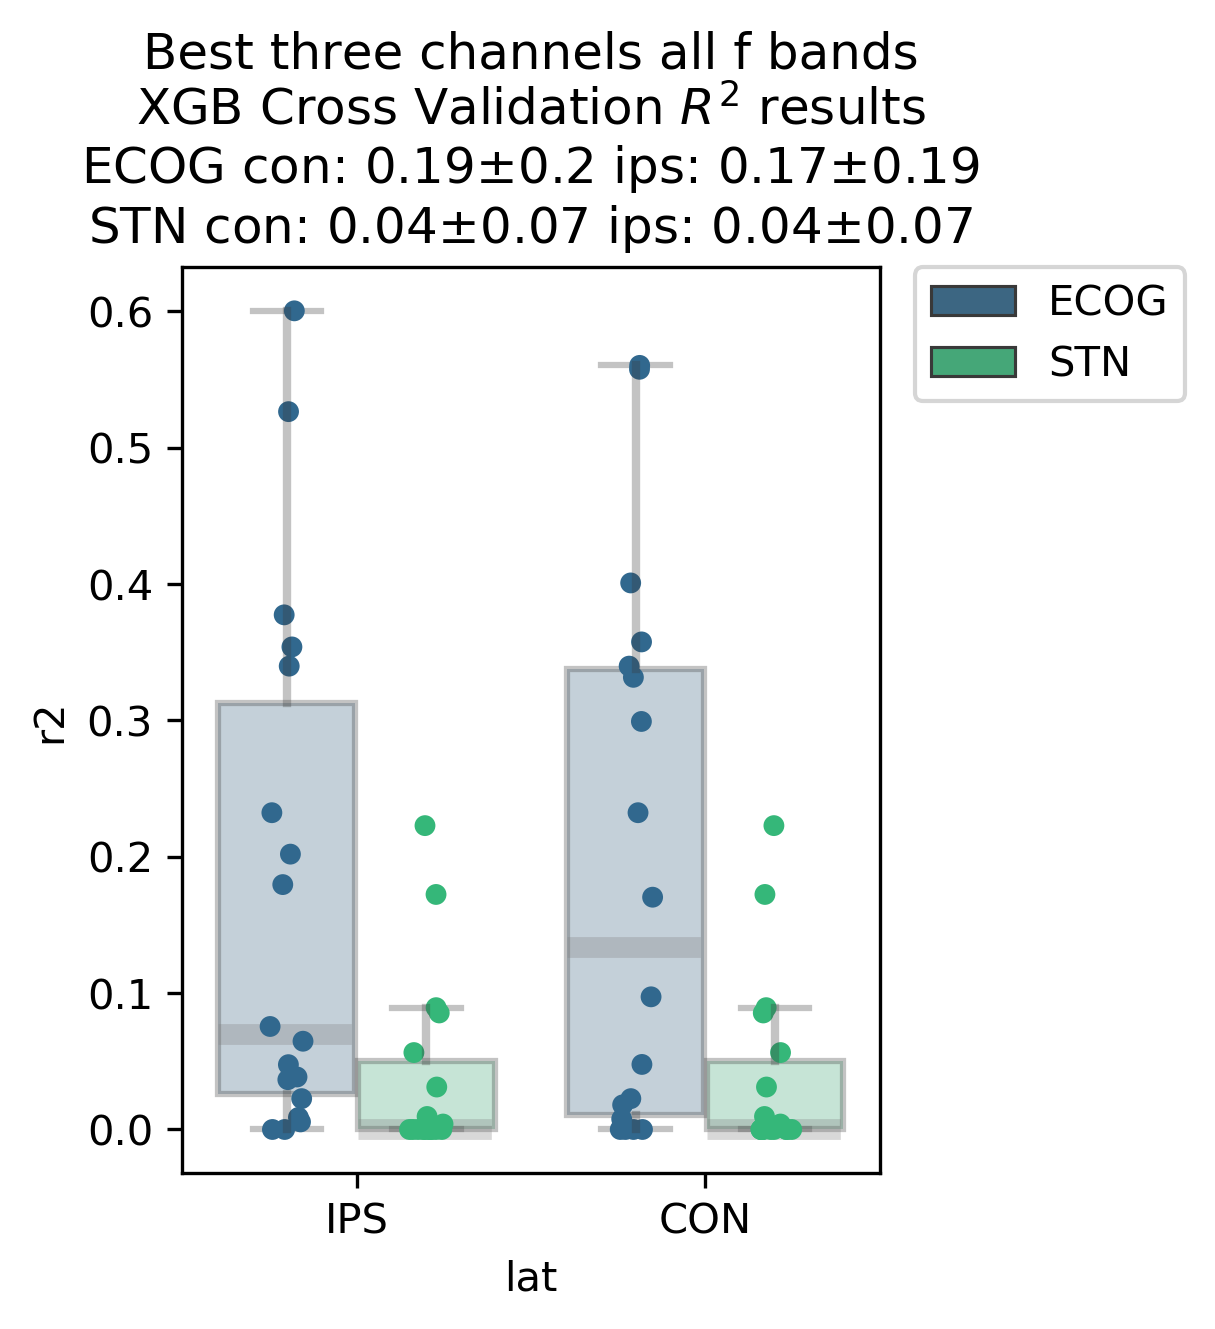

In [16]:
s_ECOG_CON = str(np.round(df_res[(df_res["lat"] == "CON") & (df_res["loc"] == "ECOG")]["r2"].mean(), 2))+\
                 r"$\pm$"+str(np.round(df_res[(df_res["lat"] == "CON") & (df_res["loc"] == "ECOG")]["r2"].std(),2))
s_ECOG_IPS = str(np.round(df_res[(df_res["lat"] == "IPS") & (df_res["loc"] == "ECOG")]["r2"].mean(), 2))+\
                 r"$\pm$"+str(np.round(df_res[(df_res["lat"] == "IPS") & (df_res["loc"] == "ECOG")]["r2"].std(),2))
s_STN_CON = str(np.round(df_res[(df_res["lat"] == "CON") & (df_res["loc"] == "STN")]["r2"].mean(), 2))+\
                 r"$\pm$"+str(np.round(df_res[(df_res["lat"] == "CON") & (df_res["loc"] == "STN")]["r2"].std(),2))
s_STN_IPS = str(np.round(df_res[(df_res["lat"] == "IPS") & (df_res["loc"] == "STN")]["r2"].mean(), 2))+\
                 r"$\pm$"+str(np.round(df_res[(df_res["lat"] == "IPS") & (df_res["loc"] == "STN")]["r2"].std(),2))


alpha_box = 0.3
plt.figure(figsize=(3,4), dpi=300)
sb.boxplot(x="lat", y="r2", hue="loc", order=["IPS", "CON"], data=df_res,
           palette="viridis", 
           showmeans=False, boxprops=dict(alpha=alpha_box), showcaps=True, showbox=True, 
           showfliers=False, notch=False,
           whiskerprops={'linewidth':2, "zorder":10, "alpha":alpha_box},
           capprops={"alpha":alpha_box},
           medianprops=dict(linestyle='-.', linewidth=5, color="gray", alpha=alpha_box))

    
ax = sb.stripplot(x="lat", y="r2", hue="loc", order=["IPS", "CON"], 
             data=df_res, palette="viridis", dodge=True, s=5)
#plt.xticks(rotation=90)

# When creating the legend, only use the first two elements
# to effectively remove the last two.
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Best three channels all f bands"+\
          "\nXGB Cross Validation "+r"$R^2$"+" results\nECOG con: "+s_ECOG_CON+ " ips: "+s_ECOG_IPS+\
         "\nSTN con: "+s_STN_CON+ " ips: "+s_STN_IPS)

### best 3 chs LM 

In [30]:
# COMBINATION ECOG
model = linear_model.LinearRegression()
df_res = pd.DataFrame()
time_stamps = 5
NUM_extract = 3

for ch_USED in [["ECOG"], ["STN"]]:
    for f in range(len(os.listdir(PATH_))):
        sub_ = os.listdir(PATH_)[f][4:7]
        if sub_ not in ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']:
            continue
        print(sub_)
        for hem in ["LEFT", "RIGHT"]:
            with open(PATH_+ '\\'+ os.listdir(PATH_)[f], 'rb') as handle:
                run_ = pickle.load(handle)
                print(run_["ch_names"])
                if len([ch for ch in run_["ch_names"] if "STN" in ch]) == 0:
                    continue

                for label_idx, label in enumerate(run_["label_baseline_corrected"]):
                    
                    if run_["label_con_true"][label_idx] is True:
                        lat = "CON"
                    else:
                        lat = "IPS"
                    if ch_USED == ["ECOG"]:
                        loc_here = "ECOG"
                    elif ch_USED == ["STN"]:
                        loc_here = "STN"
                    else:
                        loc_here = "ECOG_STN"
                    
                    #ch_idx = get_idx(run_["ch_names"], ch_USED)
                    ch_idx = get_idx_best_N(hem, lat, sub_, loc_here, run_["ch_names"], NUM_extract = NUM_extract)

                    if len(ch_idx) == 0:
                        continue
                    print("PROCESS")
                    X_ = []
                    # the LABEL is not needed here... 
                    print(ch_idx)
                    print(run_["ch_names"])
                    start = True
                    for ch_idx_ in ch_idx:
                        X, y = append_time_dim(run_["rf_data_median"][:,ch_idx_,:], \
                                               run_["label_baseline_corrected"][0,:], \
                                               time_stamps=time_stamps)
                        if start == True:
                            X_ = X
                            start = False
                        else:
                            X_ = np.concatenate((X_, X), axis=1)

                    #res_ = xgb.cv(xgb.XGBRegressor().get_params(), shuffle=False, dtrain=xgb.DMatrix(X_, label=y), 
                    #          feval=evalerror, nfold=3).iloc[-1]["test-r2-mean"]
                    res_ = np.mean(cross_val_score(linear_model.LinearRegression(),\
                                                   X_, y, cv=3, scoring="r2", n_jobs=59))
                    
                    if res_ < 0:
                        res_ = 0
                        
                    df_res = df_res.append({
                        "r2": res_,
                        #"ch_": ch_,
                        "sub": sub_,
                        "loc": loc_here,
                        "lat": lat
                    }, ignore_index=True)


000
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
000
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
000
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
000
['STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
Empty DataFrame
Columns: [ch_, hem, lat, loc, r2, sub]
Index: []
Empty DataFrame
Colu

             ch_   hem  lat   loc        r2  sub
25   ECOG_LEFT_0  LEFT  IPS  ECOG  0.064250  001
27   ECOG_LEFT_1  LEFT  IPS  ECOG  0.065847  001
29   ECOG_LEFT_2  LEFT  IPS  ECOG  0.078489  001
31   ECOG_LEFT_3  LEFT  IPS  ECOG  0.083842  001
33   ECOG_LEFT_4  LEFT  IPS  ECOG  0.094246  001
35   ECOG_LEFT_5  LEFT  IPS  ECOG  0.093902  001
37   ECOG_LEFT_6  LEFT  IPS  ECOG  0.107735  001
39   ECOG_LEFT_7  LEFT  IPS  ECOG  0.106639  001
41   ECOG_LEFT_8  LEFT  IPS  ECOG  0.099899  001
43   ECOG_LEFT_9  LEFT  IPS  ECOG  0.120339  001
45  ECOG_LEFT_10  LEFT  IPS  ECOG  0.126492  001
47  ECOG_LEFT_11  LEFT  IPS  ECOG  0.113481  001
49  ECOG_LEFT_12  LEFT  IPS  ECOG  0.084958  001
51  ECOG_LEFT_13  LEFT  IPS  ECOG  0.099823  001
53  ECOG_LEFT_14  LEFT  IPS  ECOG  0.075020  001
55  ECOG_LEFT_15  LEFT  IPS  ECOG  0.083968  001
57  ECOG_LEFT_16  LEFT  IPS  ECOG  0.080428  001
59  ECOG_LEFT_17  LEFT  IPS  ECOG  0.083866  001
61  ECOG_LEFT_18  LEFT  IPS  ECOG  0.082491  001
63  ECOG_LEFT_19  LE

['STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'ECOG_RIGHT_6', 'ECOG_RIGHT_7', 'ECOG_RIGHT_8', 'ECOG_RIGHT_9', 'ECOG_RIGHT_10', 'ECOG_RIGHT_11', 'ECOG_RIGHT_12', 'ECOG_RIGHT_13', 'ECOG_RIGHT_14', 'ECOG_RIGHT_15', 'ECOG_RIGHT_16', 'ECOG_RIGHT_17', 'ECOG_RIGHT_18', 'ECOG_RIGHT_19', 'ECOG_RIGHT_20', 'ECOG_RIGHT_21', 'ECOG_RIGHT_22', 'ECOG_RIGHT_23', 'ECOG_RIGHT_24', 'ECOG_RIGHT_25', 'ECOG_RIGHT_26', 'ECOG_RIGHT_27', 'MOV_RIGHT', 'MOV_LEFT']
               ch_    hem  lat   loc        r2  sub
86    ECOG_RIGHT_0  RIGHT  IPS  ECOG  0.033740  001
88    ECOG_RIGHT_1  RIGHT  IPS  ECOG  0.028421  001
90    ECOG_RIGHT_2  RIGHT  IPS  ECOG  0.036561  001
92    ECOG_RIGHT_3  RIGHT  IPS  ECOG  0.050552  001
94    ECOG_RIGHT_4  RIGHT  IPS  ECOG  0.066252  001
96    ECOG_RIGHT_5  RIGHT  IPS  ECOG  0.077707  001
98    ECOG_RIGHT_6  RIGHT  IPS  ECOG  0.071030  001
100   ECOG_RIGHT_7  RIGHT  IPS  ECOG  0.052281 

['STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'ECOG_RIGHT_6', 'ECOG_RIGHT_7', 'MOV_RIGHT', 'MOV_LEFT']
             ch_   hem  lat   loc        r2  sub
149  ECOG_LEFT_0  LEFT  IPS  ECOG  0.000000  004
151  ECOG_LEFT_1  LEFT  IPS  ECOG  0.000000  004
153  ECOG_LEFT_2  LEFT  IPS  ECOG  0.000000  004
155  ECOG_LEFT_3  LEFT  IPS  ECOG  0.015221  004
157  ECOG_LEFT_4  LEFT  IPS  ECOG  0.000000  004
159  ECOG_LEFT_5  LEFT  IPS  ECOG  0.000000  004
161  ECOG_LEFT_6  LEFT  IPS  ECOG  0.038585  004
163  ECOG_LEFT_7  LEFT  IPS  ECOG  0.000000  004
             ch_   hem  lat   loc   r2  sub
148  ECOG_LEFT_0  LEFT  CON  ECOG  0.0  004
150  ECOG_LEFT_1  LEFT  CON  ECOG  0.0  004
152  ECOG_LEFT_2  LEFT  CON  ECOG  0.0  004
154  ECOG_LEFT_3  LEFT  CON  ECOG  0.0  004
156  ECOG_LEFT_4  LEFT  CON  ECOG  0.0  004
158  ECOG_LEFT_5  LEFT  CON  ECOG  0.0  004
160  ECOG_LEFT_6  LEFT  CON  ECOG  0.0  004
162  ECO

006
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'ECOG_LEFT_8', 'ECOG_LEFT_9', 'ECOG_LEFT_10', 'ECOG_LEFT_11', 'ECOG_LEFT_12', 'ECOG_LEFT_13', 'ECOG_LEFT_14', 'ECOG_LEFT_15', 'ECOG_LEFT_16', 'ECOG_LEFT_17', 'ECOG_LEFT_18', 'ECOG_LEFT_19', 'ECOG_LEFT_20', 'ECOG_LEFT_21', 'ECOG_LEFT_22', 'ECOG_LEFT_23', 'ECOG_LEFT_24', 'ECOG_LEFT_25', 'ECOG_LEFT_26', 'ECOG_LEFT_27', 'ECOG_LEFT_28', 'ECOG_LEFT_29', 'ECOG_LEFT_30', 'ECOG_LEFT_31', 'ECOG_LEFT_32', 'ECOG_LEFT_33', 'ECOG_LEFT_34', 'MOV_RIGHT', 'MOV_LEFT']
              ch_   hem  lat   loc        r2  sub
236   ECOG_LEFT_0  LEFT  CON  ECOG  0.000000  006
238   ECOG_LEFT_1  LEFT  CON  ECOG  0.000000  006
240   ECOG_LEFT_2  LEFT  CON  ECOG  0.000000  006
242   ECOG_LEFT_3  LEFT  CON  ECOG  0.000000  006
244   ECOG_LEFT_4  LEFT  CON  ECOG  0.000000  006
..            ...   ...  ...   ...       ...  ...
452  ECOG_LEFT_31  LEFT  CON

              ch_   hem  lat   loc        r2  sub
237   ECOG_LEFT_0  LEFT  IPS  ECOG  0.000000  006
239   ECOG_LEFT_1  LEFT  IPS  ECOG  0.000000  006
241   ECOG_LEFT_2  LEFT  IPS  ECOG  0.000000  006
243   ECOG_LEFT_3  LEFT  IPS  ECOG  0.000000  006
245   ECOG_LEFT_4  LEFT  IPS  ECOG  0.000000  006
..            ...   ...  ...   ...       ...  ...
453  ECOG_LEFT_31  LEFT  IPS  ECOG  0.041179  006
455  ECOG_LEFT_32  LEFT  IPS  ECOG  0.019931  006
457  ECOG_LEFT_33  LEFT  IPS  ECOG  0.032975  006
459  ECOG_LEFT_34  LEFT  IPS  ECOG  0.052508  006
461  ECOG_LEFT_35  LEFT  IPS  ECOG  0.042050  006

[107 rows x 6 columns]
PROCESS
[27, 28, 29]
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'ECOG_LEFT_8', 'ECOG_LEFT_9', 'ECOG_LEFT_10', 'ECOG_LEFT_11', 'ECOG_LEFT_12', 'ECOG_LEFT_13', 'ECOG_LEFT_14', 'ECOG_LEFT_15', 'ECOG_LEFT_16', 'ECOG_LEFT_17', 'ECOG_LEFT_18', 'ECOG_LEFT_19', 'E

['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'ECOG_LEFT_8', 'ECOG_LEFT_9', 'ECOG_LEFT_10', 'ECOG_LEFT_11', 'ECOG_LEFT_12', 'ECOG_LEFT_13', 'ECOG_LEFT_14', 'ECOG_LEFT_15', 'ECOG_LEFT_16', 'ECOG_LEFT_17', 'ECOG_LEFT_18', 'ECOG_LEFT_19', 'ECOG_LEFT_20', 'ECOG_LEFT_21', 'ECOG_LEFT_22', 'ECOG_LEFT_23', 'ECOG_LEFT_24', 'ECOG_LEFT_25', 'ECOG_LEFT_26', 'ECOG_LEFT_27', 'ECOG_LEFT_28', 'ECOG_LEFT_29', 'ECOG_LEFT_30', 'ECOG_LEFT_31', 'ECOG_LEFT_32', 'ECOG_LEFT_33', 'ECOG_LEFT_34', 'ECOG_LEFT_35', 'MOV_RIGHT', 'MOV_LEFT']
               ch_    hem  lat   loc        r2  sub
469   ECOG_RIGHT_0  RIGHT  CON  ECOG  0.000000  006
471   ECOG_RIGHT_1  RIGHT  CON  ECOG  0.000000  006
473   ECOG_RIGHT_2  RIGHT  CON  ECOG  0.000000  006
475   ECOG_RIGHT_3  RIGHT  CON  ECOG  0.000000  006
477   ECOG_RIGHT_4  RIGHT  CON  ECOG  0.000000  006
479   ECOG_RIGHT_5  RIGHT  CON  ECOG  0.000000  006
48

['STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'ECOG_RIGHT_6', 'ECOG_RIGHT_7', 'ECOG_RIGHT_8', 'ECOG_RIGHT_9', 'ECOG_RIGHT_10', 'ECOG_RIGHT_11', 'ECOG_RIGHT_12', 'ECOG_RIGHT_13', 'ECOG_RIGHT_14', 'ECOG_RIGHT_15', 'ECOG_RIGHT_16', 'ECOG_RIGHT_17', 'ECOG_RIGHT_18', 'ECOG_RIGHT_19', 'ECOG_RIGHT_20', 'ECOG_RIGHT_21', 'ECOG_RIGHT_22', 'ECOG_RIGHT_23', 'ECOG_RIGHT_24', 'ECOG_RIGHT_25', 'ECOG_RIGHT_26', 'ECOG_RIGHT_27', 'ECOG_RIGHT_28', 'ECOG_RIGHT_29', 'ECOG_RIGHT_30', 'ECOG_RIGHT_31', 'ECOG_RIGHT_32', 'ECOG_RIGHT_33', 'ECOG_RIGHT_34', 'ECOG_RIGHT_35', 'MOV_RIGHT', 'MOV_LEFT']
               ch_    hem  lat   loc        r2  sub
468   ECOG_RIGHT_0  RIGHT  IPS  ECOG  0.000000  006
470   ECOG_RIGHT_1  RIGHT  IPS  ECOG  0.000000  006
472   ECOG_RIGHT_2  RIGHT  IPS  ECOG  0.000000  006
474   ECOG_RIGHT_3  RIGHT  IPS  ECOG  0.000000  006
476   ECOG_RIGHT_4  RIGHT  IPS  ECOG  0.000000  006
478   ECOG_RIGH

             ch_   hem  lat   loc   r2  sub
565  ECOG_LEFT_0  LEFT  IPS  ECOG  0.0  008
567  ECOG_LEFT_1  LEFT  IPS  ECOG  0.0  008
569  ECOG_LEFT_2  LEFT  IPS  ECOG  0.0  008
571  ECOG_LEFT_3  LEFT  IPS  ECOG  0.0  008
573  ECOG_LEFT_4  LEFT  IPS  ECOG  0.0  008
575  ECOG_LEFT_5  LEFT  IPS  ECOG  0.0  008
PROCESS
[3, 4, 5]
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
Empty DataFrame
Columns: [ch_, hem, lat, loc, r2, sub]
Index: []
Empty DataFrame
Columns: [ch_, hem, lat, loc, r2, sub]
Index: []
008
['ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
['ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV

              ch_    hem  lat   loc        r2  sub
619  ECOG_RIGHT_0  RIGHT  CON  ECOG  0.174412  010
621  ECOG_RIGHT_1  RIGHT  CON  ECOG  0.067529  010
623  ECOG_RIGHT_2  RIGHT  CON  ECOG  0.028692  010
625  ECOG_RIGHT_3  RIGHT  CON  ECOG  0.005757  010
627  ECOG_RIGHT_4  RIGHT  CON  ECOG  0.000000  010
629  ECOG_RIGHT_5  RIGHT  CON  ECOG  0.017282  010
PROCESS
[3, 4, 5]
['STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
013
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
             ch_   hem  lat   loc        r2  sub
636  ECOG_LEFT_0  LEFT  CON  ECOG  0.086586  013
638  ECOG_LEFT_1  LEFT  CON  ECOG  0.070421  013
640  ECOG_LEFT_2  LEFT  CON  ECOG  0.074926  013
642  ECOG_LEFT_3  LEFT  CON  ECOG  0.102900  013
644  ECOG_LEFT_4  LEFT  CON  ECOG  0.081683  013
64

['ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'ECOG_LEFT_8', 'ECOG_LEFT_9', 'ECOG_LEFT_10', 'ECOG_LEFT_11', 'ECOG_LEFT_12', 'ECOG_LEFT_13', 'ECOG_LEFT_14', 'ECOG_LEFT_15', 'ECOG_LEFT_16', 'ECOG_LEFT_17', 'ECOG_LEFT_18', 'ECOG_LEFT_19', 'ECOG_LEFT_20', 'ECOG_LEFT_21', 'ECOG_LEFT_22', 'ECOG_LEFT_23', 'ECOG_LEFT_24', 'ECOG_LEFT_25', 'ECOG_LEFT_26', 'ECOG_LEFT_27', 'MOV_RIGHT', 'MOV_LEFT']
001
['ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'ECOG_LEFT_8', 'ECOG_LEFT_9', 'ECOG_LEFT_10', 'ECOG_LEFT_11', 'ECOG_LEFT_12', 'ECOG_LEFT_13', 'ECOG_LEFT_14', 'ECOG_LEFT_15', 'ECOG_LEFT_16', 'ECOG_LEFT_17', 'ECOG_LEFT_18', 'ECOG_LEFT_19', 'ECOG_LEFT_20', 'ECOG_LEFT_21', 'ECOG_LEFT_22', 'ECOG_LEFT_23', 'ECOG_LEFT_24', 'ECOG_LEFT_25', 'ECOG_LEFT_26', 'ECOG_LEFT_27', 'MOV_RIGHT', 'MOV_LEFT']
['ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_L

['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'ECOG_RIGHT_6', 'ECOG_RIGHT_7', 'ECOG_RIGHT_8', 'ECOG_RIGHT_9', 'ECOG_RIGHT_10', 'ECOG_RIGHT_11', 'ECOG_RIGHT_12', 'ECOG_RIGHT_13', 'ECOG_RIGHT_14', 'ECOG_RIGHT_15', 'ECOG_RIGHT_16', 'ECOG_RIGHT_17', 'ECOG_RIGHT_18', 'ECOG_RIGHT_19', 'ECOG_RIGHT_20', 'ECOG_RIGHT_21', 'ECOG_RIGHT_22', 'ECOG_RIGHT_23', 'ECOG_RIGHT_24', 'ECOG_RIGHT_25', 'ECOG_RIGHT_26', 'ECOG_RIGHT_27', 'MOV_RIGHT', 'MOV_LEFT']
004
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'MOV_RIGHT', 'MOV_LEFT']
            ch_   hem  lat  loc        r2  sub
142  STN_LEFT_0  LEFT  CON  STN  0.000000  004
144  STN_LEFT_1  LEFT  CON  STN  0.003399  004
146  STN_LEFT_2  LEFT  CON  STN  0.000000  004
PROCESS
[0, 1, 2]
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_L

            ch_   hem  lat  loc        r2  sub
231  STN_LEFT_0  LEFT  IPS  STN  0.024502  006
233  STN_LEFT_1  LEFT  IPS  STN  0.051060  006
235  STN_LEFT_2  LEFT  IPS  STN  0.052100  006
307  STN_LEFT_0  LEFT  IPS  STN  0.056999  006
309  STN_LEFT_1  LEFT  IPS  STN  0.015261  006
311  STN_LEFT_2  LEFT  IPS  STN  0.023766  006
385  STN_LEFT_0  LEFT  IPS  STN  0.000000  006
387  STN_LEFT_1  LEFT  IPS  STN  0.000000  006
389  STN_LEFT_2  LEFT  IPS  STN  0.000000  006
PROCESS
[0, 1, 2]
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'ECOG_LEFT_8', 'ECOG_LEFT_9', 'ECOG_LEFT_10', 'ECOG_LEFT_11', 'ECOG_LEFT_12', 'ECOG_LEFT_13', 'ECOG_LEFT_14', 'ECOG_LEFT_15', 'ECOG_LEFT_16', 'ECOG_LEFT_17', 'ECOG_LEFT_18', 'ECOG_LEFT_19', 'ECOG_LEFT_20', 'ECOG_LEFT_21', 'ECOG_LEFT_22', 'ECOG_LEFT_23', 'ECOG_LEFT_24', 'ECOG_LEFT_25', 'ECOG_LEFT_26', 'ECOG_LEFT_27', 'ECOG_LEFT_28', 'ECOG_LEFT_29',

['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'ECOG_LEFT_8', 'ECOG_LEFT_9', 'ECOG_LEFT_10', 'ECOG_LEFT_11', 'ECOG_LEFT_12', 'ECOG_LEFT_13', 'ECOG_LEFT_14', 'ECOG_LEFT_15', 'ECOG_LEFT_16', 'ECOG_LEFT_17', 'ECOG_LEFT_18', 'ECOG_LEFT_19', 'ECOG_LEFT_20', 'ECOG_LEFT_21', 'ECOG_LEFT_22', 'ECOG_LEFT_23', 'ECOG_LEFT_24', 'ECOG_LEFT_25', 'ECOG_LEFT_26', 'ECOG_LEFT_27', 'ECOG_LEFT_28', 'ECOG_LEFT_29', 'ECOG_LEFT_30', 'ECOG_LEFT_31', 'ECOG_LEFT_32', 'ECOG_LEFT_33', 'ECOG_LEFT_34', 'ECOG_LEFT_35', 'MOV_RIGHT', 'MOV_LEFT']
             ch_    hem  lat  loc   r2  sub
463  STN_RIGHT_0  RIGHT  CON  STN  0.0  006
465  STN_RIGHT_1  RIGHT  CON  STN  0.0  006
467  STN_RIGHT_2  RIGHT  CON  STN  0.0  006
             ch_    hem  lat  loc   r2  sub
462  STN_RIGHT_0  RIGHT  IPS  STN  0.0  006
464  STN_RIGHT_1  RIGHT  IPS  STN  0.0  006
466  STN_RIGHT_2  RIGHT  IPS  STN  0.0  006
006
['ECOG_RIG

            ch_   hem  lat  loc        r2  sub
541  STN_LEFT_0  LEFT  IPS  STN  0.005384  007
543  STN_LEFT_1  LEFT  IPS  STN  0.000000  007
545  STN_LEFT_2  LEFT  IPS  STN  0.000000  007
PROCESS
[0, 1, 2]
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
Empty DataFrame
Columns: [ch_, hem, lat, loc, r2, sub]
Index: []
Empty DataFrame
Columns: [ch_, hem, lat, loc, r2, sub]
Index: []
008
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
            ch_   hem  lat  loc        r2  sub
558  STN_LEFT_0  LEFT  CON  STN  0.011195  008
560  STN_LEFT_1  LEFT  CON  STN  0.000000  008
562  STN_LEFT_2  LEFT  CON  STN  0.000000  00

             ch_    hem  lat  loc        r2  sub
613  STN_RIGHT_0  RIGHT  CON  STN  0.000000  010
615  STN_RIGHT_1  RIGHT  CON  STN  0.016340  010
617  STN_RIGHT_2  RIGHT  CON  STN  0.038222  010
PROCESS
[0, 1, 2]
['STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
013
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
            ch_   hem  lat  loc   r2  sub
630  STN_LEFT_0  LEFT  CON  STN  0.0  013
632  STN_LEFT_1  LEFT  CON  STN  0.0  013
634  STN_LEFT_2  LEFT  CON  STN  0.0  013
PROCESS
[0, 1, 2]
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
            ch_   hem  lat  loc   r2  sub
631  STN_LEFT_0  LEFT  IPS  STN  0.0  013
633  STN_LEFT_1  LEFT  IPS  S

Text(0.5, 1.0, 'Best three channels all f bands\nLM Cross Validation $R^2$ results\nECOG con: 0.11$\\pm$0.12 ips: 0.1$\\pm$0.11\nSTN con: 0.03$\\pm$0.07 ips: 0.03$\\pm$0.07')

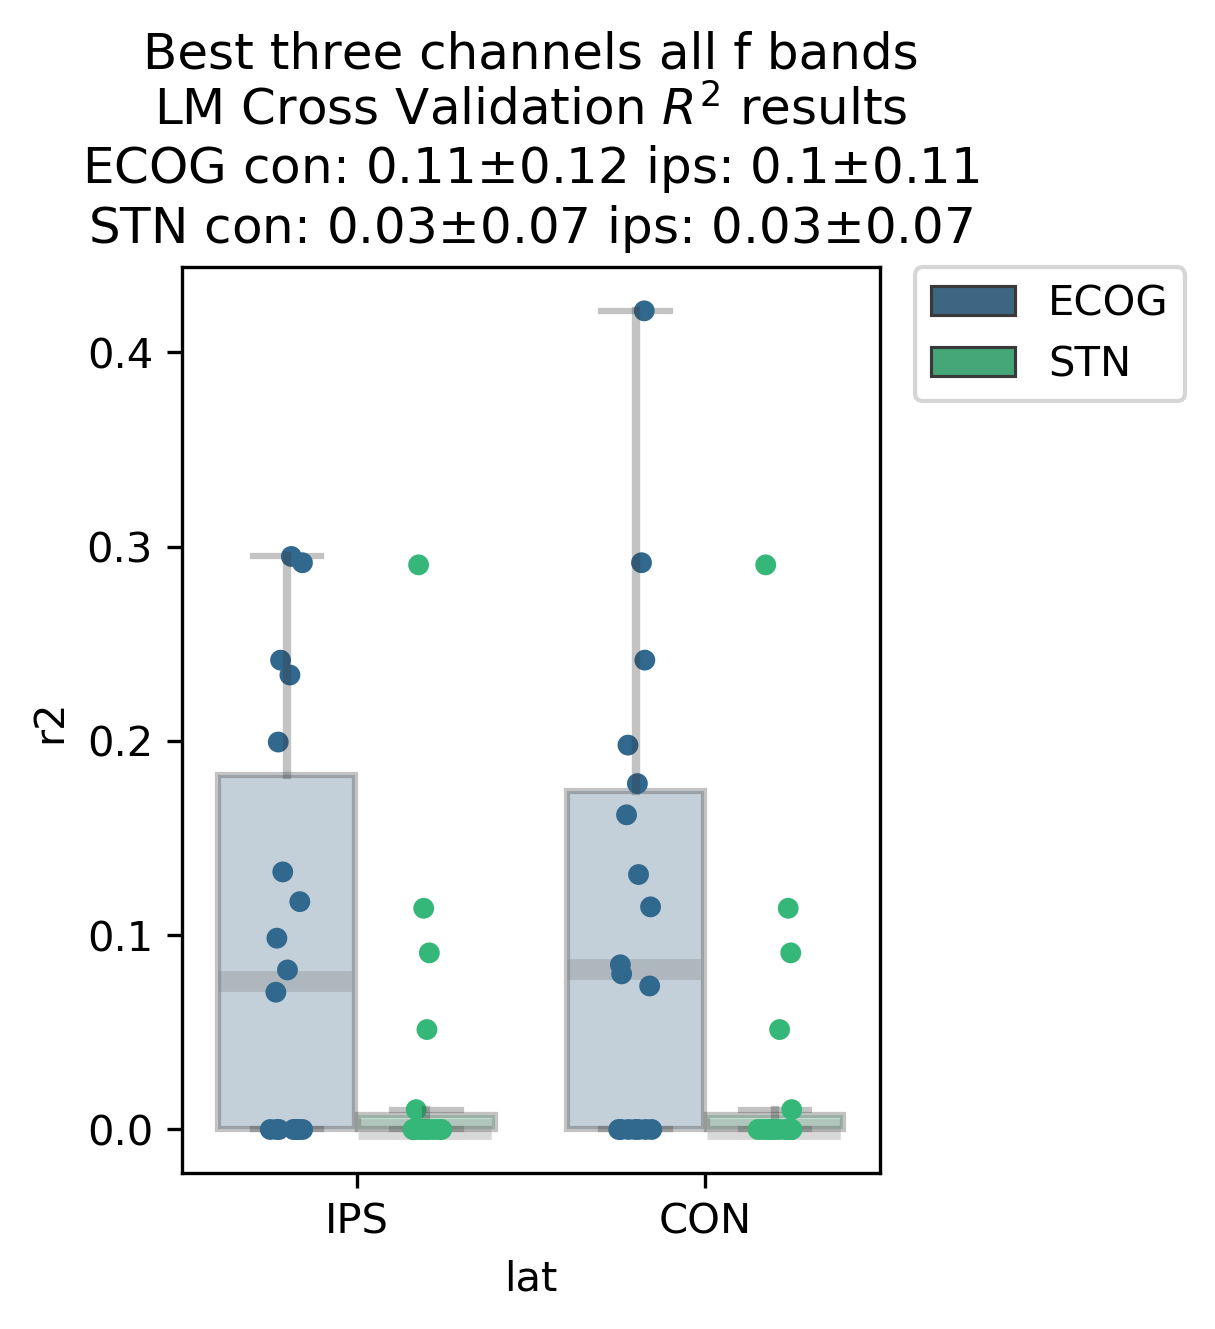

In [31]:
s_ECOG_CON = str(np.round(df_res[(df_res["lat"] == "CON") & (df_res["loc"] == "ECOG")]["r2"].mean(), 2))+\
                 r"$\pm$"+str(np.round(df_res[(df_res["lat"] == "CON") & (df_res["loc"] == "ECOG")]["r2"].std(),2))
s_ECOG_IPS = str(np.round(df_res[(df_res["lat"] == "IPS") & (df_res["loc"] == "ECOG")]["r2"].mean(), 2))+\
                 r"$\pm$"+str(np.round(df_res[(df_res["lat"] == "IPS") & (df_res["loc"] == "ECOG")]["r2"].std(),2))
s_STN_CON = str(np.round(df_res[(df_res["lat"] == "CON") & (df_res["loc"] == "STN")]["r2"].mean(), 2))+\
                 r"$\pm$"+str(np.round(df_res[(df_res["lat"] == "CON") & (df_res["loc"] == "STN")]["r2"].std(),2))
s_STN_IPS = str(np.round(df_res[(df_res["lat"] == "IPS") & (df_res["loc"] == "STN")]["r2"].mean(), 2))+\
                 r"$\pm$"+str(np.round(df_res[(df_res["lat"] == "IPS") & (df_res["loc"] == "STN")]["r2"].std(),2))


alpha_box = 0.3
plt.figure(figsize=(3,4), dpi=300)
sb.boxplot(x="lat", y="r2", hue="loc", order=["IPS", "CON"], data=df_res,
           palette="viridis", 
           showmeans=False, boxprops=dict(alpha=alpha_box), showcaps=True, showbox=True, 
           showfliers=False, notch=False,
           whiskerprops={'linewidth':2, "zorder":10, "alpha":alpha_box},
           capprops={"alpha":alpha_box},
           medianprops=dict(linestyle='-.', linewidth=5, color="gray", alpha=alpha_box))

    
ax = sb.stripplot(x="lat", y="r2", hue="loc", order=["IPS", "CON"], 
             data=df_res, palette="viridis", dodge=True, s=5)
#plt.xticks(rotation=90)

# When creating the legend, only use the first two elements
# to effectively remove the last two.
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Best three channels all f bands"+\
          "\nLM Cross Validation "+r"$R^2$"+" results\nECOG con: "+s_ECOG_CON+ " ips: "+s_ECOG_IPS+\
         "\nSTN con: "+s_STN_CON+ " ips: "+s_STN_IPS)

In [32]:
s_ECOG_IPS

'0.1$\\pm$0.11'